# Lab Practice: Online Learning
**Interuniversity Master’s Degree in Artificial Intelligence**  
**Course:** Machine Learing II (MLII)  
**Academic Year:** 2025–2026  

---

## Group Members
- Cristian Marquina
- Francisco Vázquez
- Jose Carlos Bordón Maldonado
- Daniel González Filgueira
- Gian Paolo Belleddu

---

## Problem Description
The goal of this project is to predict the future price of a financial asset (specifically, the "High" price of the SPY ETF five days into the future). By forecasting these values, we aim to provide a tool that helps in anticipating market trends and making informed investment decisions.

Machine Learning Viewpoint:
* Problem Type: This is a regression problem, as the target variable ($Target\_High$) is a continuous numerical value representing a stock price.
* Imbalance: While not a classification problem (where class imbalance is typical), we have to take into account that the presence of volatility in stock prices is very likely to bias the model and provoke not very good results.
* Influence of Drift: Financial markets are highly dynamic. The dataset is likely influenced by concept drift due to changing economic cycles, interest rate updates, or geopolitical events.
* Evaluation Metrics: We use Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) to measure performance.
* Assumptions: We assume that historical patterns in price and volume contain predictive information and that the temporal order must be strictly preserved.

---

### Project Overview and Methodology

The primary objective of this project is to evaluate and compare two distinct machine learning paradigms: **Batch Learning** and **Stream (Online) Learning**. We utilize a financial time-series dataset (the SPY ETF) as a practical testbed to observe algorithmic behavior in a highly non-stationary environment. 

In many real-world machine learning applications, the statistical properties of the target variable change over time—a phenomenon known as **Concept Drift**. By training static batch models (Random Forest, Gradient Boosting, MLP) and monitoring their degradation, we establish a baseline of how offline models fail when data distributions shift. We then implement adaptive stream models (Hoeffding Trees, Online Linear Regression, and Streaming Random Patches) using the `River` library. The ultimate goal is to highlight the theoretical and practical differences between offline pattern recognition and continuous, incremental algorithmic adaptation.

---
## Dataset Selection
The selected dataset contains historical stock prices for the SPY ETF.

* Suitability for Stream Learning: It contains a clear temporal component (daily records), which is essential for simulating a data stream.

* Origin: This is an external dataset (from Kaggle), providing a more realistic and complex scenario than built-in library datasets.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import tensorflow as tf

# Batch Libraries (Scikit-Learn)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Deep Learning Libraries (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Online Libraries (River)
from river import compose, tree, metrics, preprocessing, neighbors, linear_model, optim, ensemble, drift

# Utilities
from lab1_utils import *

# Configuration
DATA_DIR = 'data/'
IMG_DIR = 'images/'

# Seeds for reproducibility. River seeds are set in the model definitions (KNN and Linear Regression do not have a seed parameter)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Data loading and target preparation

In [9]:
# Load dataset
file_path = DATA_DIR + 'spy.us.txt'
df = pd.read_csv(file_path)

# Delete 'OpenInt' column (always 0 value)
if 'OpenInt' in df.columns:
    df = df.drop(columns=['OpenInt'])
    print("'OpenInt' column deleted successfully")

print(f"Initial number of rows: {len(df)}")

# Delete rows with missing values
df_cleaned = df.dropna()

print(f"Final columns: {df_cleaned.columns.tolist()}")
print(f"Final number of rows: {len(df_cleaned)}")

# Save cleaned dataset
df_cleaned.to_csv(DATA_DIR + 'spy_cleaned.csv', index=False)

'OpenInt' column deleted successfully
Initial number of rows: 3201
Final columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Final number of rows: 3201


In [10]:
# Load cleaned dataset
df = pd.read_csv(DATA_DIR + 'spy_cleaned.csv')

# Create the target: the 'High' 5 records ahead
# shift(-5) moves the values up by 5 positions.
# We are now predicting the value 5 days into the future to avoid naive correlation.
df['Target_High'] = df['High'].shift(-5)

# The last 5 rows do not have a "5th day future," so they become null (NaN)
df = df.dropna(subset=['Target_High'])

# Verify that Target_High is indeed the next day's High
print("\nFirst rows of the transformed dataset:")
df[['Date', 'High', 'Target_High']].head(21)


First rows of the transformed dataset:


Date    High  Target_High
0   2005-02-25  106.00       107.01
1   2005-02-28  105.68       107.38
2   2005-03-01  105.87       107.15
3   2005-03-02  106.22       106.52
4   2005-03-03  106.20       105.85
5   2005-03-04  107.01       106.04
6   2005-03-07  107.38       105.56
7   2005-03-08  107.15       105.82
8   2005-03-09  106.52       104.44
9   2005-03-10  105.85       104.31
10  2005-03-11  106.04       104.13
11  2005-03-14  105.56       103.48
12  2005-03-15  105.82       103.60
13  2005-03-16  104.44       102.56
14  2005-03-17  104.31       102.79
15  2005-03-18  104.13       102.75
16  2005-03-21  103.48       102.71
17  2005-03-22  103.60       102.98
18  2005-03-23  102.56       103.19
19  2005-03-24  102.79       103.66
20  2005-03-28  102.75       102.67

## Batch Learning

### Feature extraction and data splitting

### Feature Extraction and Data Preparation

Before feeding the dataset into our models, we extract several financial indicators from the raw data. Stock prices are notoriously noisy, so providing the model with engineered features like volatility and moving averages helps it identify underlying trends rather than just reacting to the raw daily price.

These features are computed identically for both our Batch models (using pandas in `get_batch_features_and_target`) and our Stream models (using River's `base.Transformer` in the `OnlineSPYFeatures` class).

**Engineered Features:**
* **`Return`**: The daily percentage change in the closing price. This is a standard financial metric that normalizes the price movement.
* **`Mean_return_5` & `Mean_return_20`**: The rolling average of the returns over the last 5 days (1 week) and 20 days (1 month). These capture short-term and medium-term momentum.
* **`Volatility_20`**: The rolling standard deviation of the returns over the last 20 days. This is crucial for financial data, as periods of high volatility often precede significant market shifts or concept drift.
* **`Open_Close_Diff`**: The difference between the closing and opening price of the day (`Close - Open`). It indicates the intraday price action and market sentiment (bullish vs. bearish).
* **`Volume_dev`**: The difference between the current day's trading volume and the 20-day moving average volume. Unusually high volume often signals strong conviction behind a price movement.

**Data Preparation:**
* **Missing Values:** The rolling windows of 20 days naturally produce `NaN` values for the first 20 rows of the dataset. These rows are dropped to ensure clean training data.
* **River Format Adaptation:** For the online stream learning section, the models in River cannot process Pandas DataFrames directly. The data is processed instance-by-instance, where each row is converted into a Python dictionary before being passed to `predict_one` and `learn_one`.

In [11]:
# Data Splitting (Temporal Split - NO SHUFFLE): 70% training, 15% validation, and 15% test
n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

print(f"Total samples: {n}")

# Generate features and target for the entire dataset (train + val + test) to ensure we have the necessary history for feature generation
# This prevents the first 20 rows of the validation or test sets from becoming NaN due to insufficient historical data
X_full, y_full = get_batch_features_and_target(df)
print(f"Full shapes: X={X_full.shape}, y={y_full.shape}")

# Data splitting based on indices making sure that the cut respects the reduced dataframe after feature generation
X_train = X_full.loc[X_full.index < train_end]
y_train = y_full.loc[y_full.index < train_end]

X_val = X_full.loc[(X_full.index >= train_end) & (X_full.index < val_end)]
y_val = y_full.loc[(y_full.index >= train_end) & (y_full.index < val_end)]

X_test = X_full.loc[X_full.index >= val_end]
y_test = y_full.loc[y_full.index >= val_end]

print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Val shapes: X={X_val.shape}, y={y_val.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Total samples: 3196
Full shapes: X=(3176, 8), y=(3176,)
Train shapes: X=(2217, 8), y=(2217,)
Val shapes: X=(479, 8), y=(479,)
Test shapes: X=(480, 8), y=(480,)


In [12]:
X_train.head()

Close    Return  Mean_return_5  Mean_return_20  Volatility_20  \
20  102.19  0.001372      -0.002071       -0.001712       0.005964   
21  101.51 -0.006654      -0.002686       -0.001709       0.005962   
22  102.96  0.014284       0.002193       -0.001252       0.006766   
23  102.77 -0.001845       0.001667       -0.001320       0.006765   
24  102.30 -0.004573       0.000517       -0.001568       0.006789   

    Open_Close_Diff     Volume   Volume_dev  
20            -0.10   53885043 -15613298.30  
21            -0.54   83849903  14143833.75  
22             1.11   72199510   1613835.85  
23            -0.20   74669192   4036712.75  
24            -1.04  111800673  39142501.25

In [13]:
y_train.head()

20    102.67
21    103.12
22    103.62
23    103.89
24    103.85
Name: Target_High, dtype: float64

In [14]:
# Scale the data (standarization) to avoid inestability
scaler = StandardScaler()
# Obtain mean and std from the training data only to prevent data leakage
scaler.fit(X_train)

# Transfrom all sets with the obtained parameters from training set
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Shapes after scaling:")
print(f"Train shapes: X={X_train_scaled.shape}, y={y_train.shape}")
print(f"Val shapes: X={X_val_scaled.shape}, y={y_val.shape}")
print(f"Test shapes: X={X_test_scaled.shape}, y={y_test.shape}")

Shapes after scaling:
Train shapes: X=(2217, 8), y=(2217,)
Val shapes: X=(479, 8), y=(479,)
Test shapes: X=(480, 8), y=(480,)


### Model 1: Random Forest Regressor

Our first batch model is a **Random Forest Regressor**, an ensemble method that builds multiple decision trees and averages their predictions. 

**Time-Series Cross-Validation Strategy:**
Standard cross-validation is dangerous for financial data because it randomly shuffles the dataset. This would cause data leakage—allowing the model to "peek" into future prices to predict past prices. 

To prevent this, we utilize Scikit-Learn's `PredefinedSplit`. By concatenating the scaled training and validation sets and explicitly marking the training samples with an index of `-1` and the validation samples with `0`, we force `GridSearchCV` to train strictly on the chronological training fold and validate only on the subsequent validation fold. 

We tuned three key hyperparameters:
* **`max_depth`**: To control the maximum depth of the trees.
* **`min_samples_leaf`**: To prevent overfitting by requiring a minimum number of samples at the end of each branch.
* **`max_features`**: The subset of features considered for splitting.

In [ ]:
param_grid = {
    'max_depth':        [5, 10, 15, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features':     ['sqrt', 0.5, 1.0],
}

# PredefinedSplit ensures the validation fold is always the same predefined split,
# preventing GridSearchCV from randomly shuffling the data across folds.
# This is critical for time series data, where future data must never be used to train the model.
# -1 = training samples, 0 = validation samples
split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
ps = PredefinedSplit(split_index)

X_trainval = np.concatenate([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train, y_val])

grid_search = GridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    param_grid,
    cv=ps,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search.fit(X_trainval, y_trainval)

print(f"Best param: {grid_search.best_params_}")
print(f"Best Val MAE:      {-grid_search.best_score_:.4f}")

Fitting 1 folds for each of 48 candidates, totalling 48 fits
Best param: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 5}
Best Val MAE:      19.4975


best one: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 5}

Plot saved as 'images/best_train_predictions_rf.png'


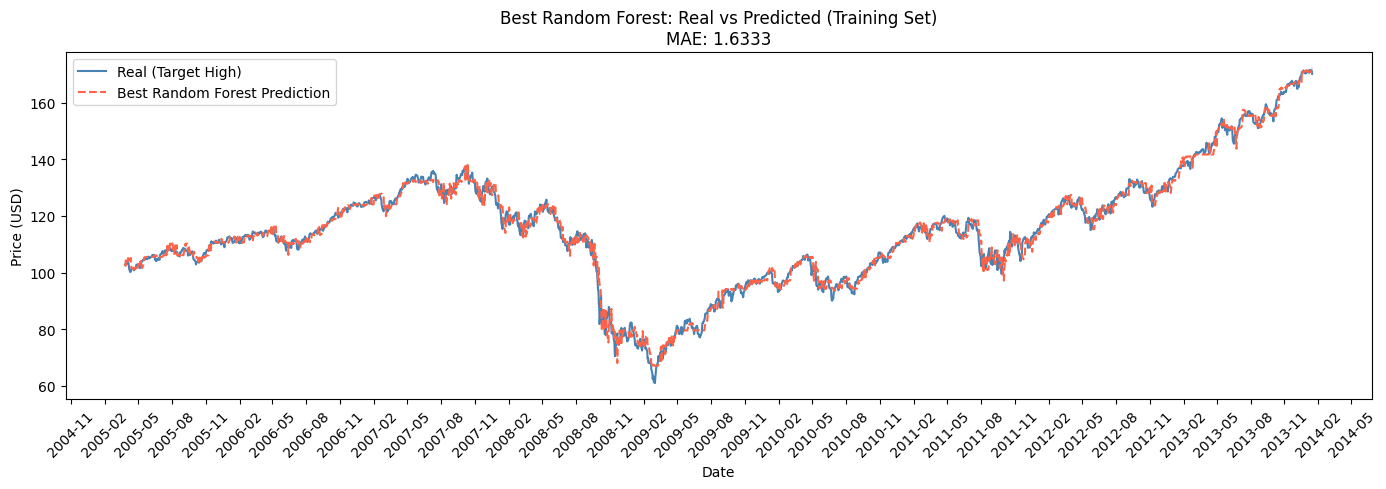

Plot saved as 'images/best_validation_predictions_rf.png'


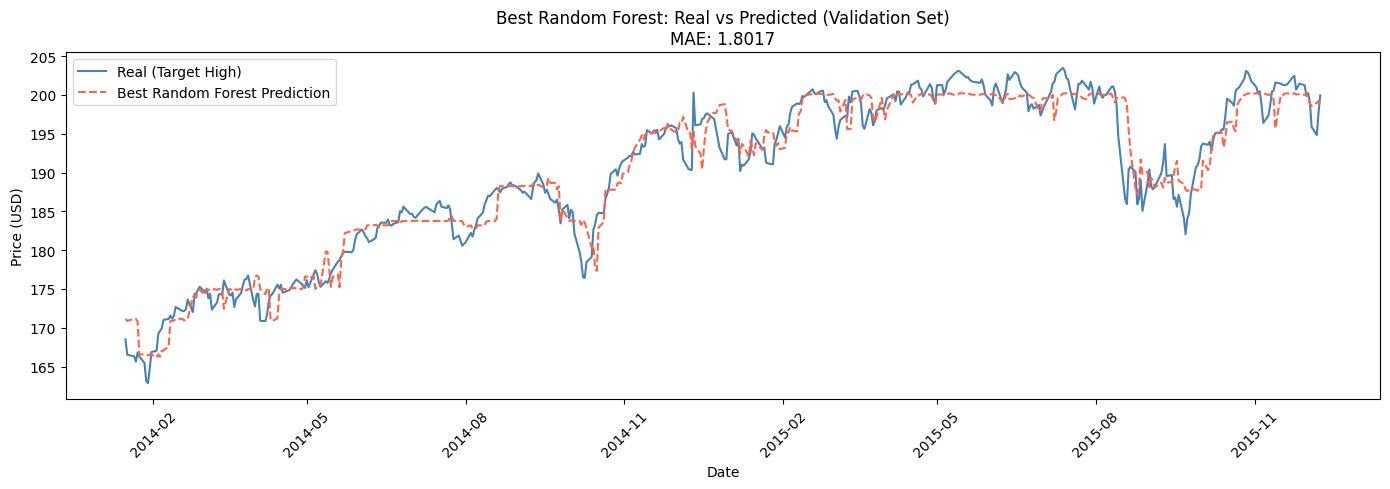

Plot saved as 'images/best_test_predictions_rf.png'


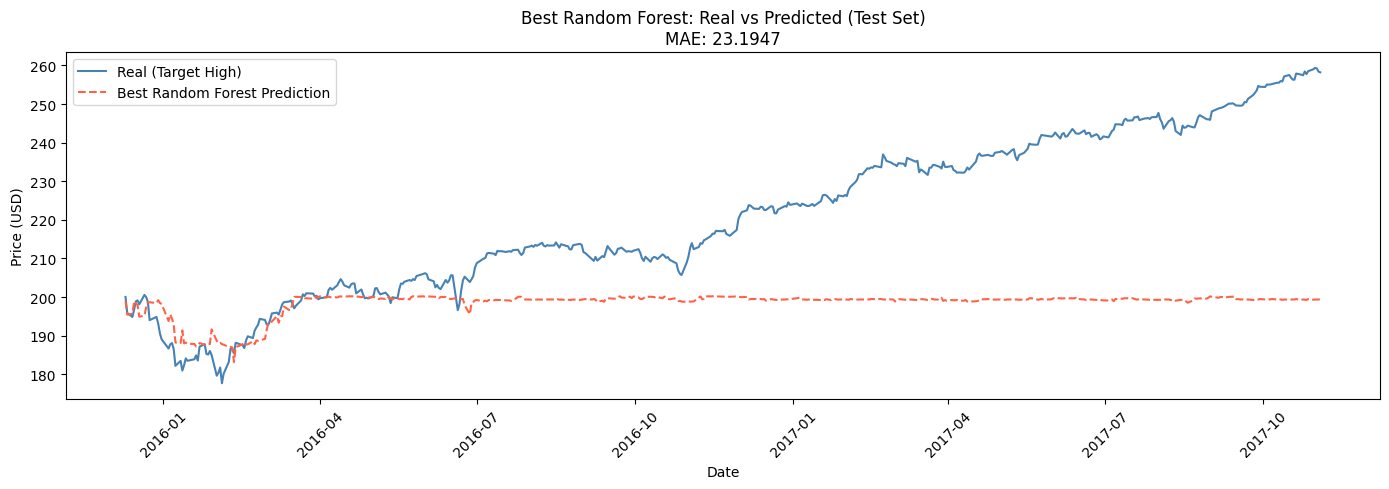

Best RF -> Train MAE: 1.6333
Best RF -> Val MAE:   1.8017
Best RF -> Test MAE:  23.1947


In [16]:
best_rf = grid_search.best_estimator_

print(f"best one: {grid_search.best_params_}\n")

mae_best_train = plot_predictions(best_rf, X_train_scaled, y_train, df, 'Training',   'Best Random Forest', filename=IMG_DIR + 'best_train_predictions_rf.png')
mae_best_val   = plot_predictions(best_rf, X_val_scaled,   y_val,   df, 'Validation', 'Best Random Forest', filename=IMG_DIR + 'best_validation_predictions_rf.png')
mae_best_test  = plot_predictions(best_rf, X_test_scaled,  y_test,  df, 'Test',       'Best Random Forest', filename=IMG_DIR + 'best_test_predictions_rf.png')

print(f"Best RF -> Train MAE: {mae_best_train:.4f}")
print(f"Best RF -> Val MAE:   {mae_best_val:.4f}")
print(f"Best RF -> Test MAE:  {mae_best_test:.4f}")

### Random Forest: Results and Limitations

After executing the grid search, the optimal hyperparameters were found to be `max_depth=5`, `min_samples_leaf=5`, and `max_features=1.0`. 

**Analyzing the Test MAE and the "Flattening" Effect:**
While the model achieved a reasonable Validation MAE, observing the test set predictions reveals a significant limitation: the prediction line completely **flattens out** as time progresses. 

This happens because of a fundamental characteristic of standard Random Forest models: **they cannot extrapolate**. A Random Forest makes predictions by averaging the target values of the training samples that fall into a specific leaf node. Therefore, the model can *never* predict a price higher than the maximum price it saw during the training period. 

Because the SPY ETF exhibits a strong long-term upward trend, the actual stock prices in the test set eventually surpass the historical maximums. Once the market enters this "uncharted territory," the Random Forest simply caps out, repeatedly predicting the highest value it remembers from the training set. This causes the flatline behavior and ultimately results in a degraded Test MAE, highlighting why static, non-extrapolating batch models struggle with trending financial streams.

---

### Model 2: Gradient Boosting Regressor

Our second batch model is a **Gradient Boosting Regressor**. While Random Forest builds independent trees in parallel, Gradient Boosting builds trees sequentially. Each new tree in the sequence is specifically trained to correct the residual errors made by the combination of all previous trees, making it a highly powerful additive model.

**Hyperparameter Tuning:**
We continue using the `PredefinedSplit` strategy defined earlier to strictly separate our chronological training and validation folds, ensuring no future data leaks into the training process. 

For this model, we tuned three specific hyperparameters:
* **`n_estimators`**: The total number of sequential boosting stages (trees) to perform.
* **`learning_rate`**: Shrinks the contribution of each individual tree. There is a fundamental trade-off between `learning_rate` and `n_estimators`.
* **`max_depth`**: Limits the number of nodes in each individual regression estimator, controlling the complexity of the trees.

In [ ]:
param_grid_gb = {
    'n_estimators':     [100, 200],
    'learning_rate':    [0.01, 0.05, 0.1],
    'max_depth':        [3, 5, 7],
    'min_samples_leaf': [1, 5, 10],
}

split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
ps = PredefinedSplit(split_index)

X_trainval = np.concatenate([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train, y_val])

grid_search_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=ps,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search_gb.fit(X_trainval, y_trainval)

print(f"Best params: {grid_search_gb.best_params_}")
print(f"Best Val MAE: {-grid_search_gb.best_score_:.4f}")

Fitting 1 folds for each of 54 candidates, totalling 54 fits
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
Best Val MAE: 19.2517


Plot saved as 'images/best_train_predictions_gb.png'


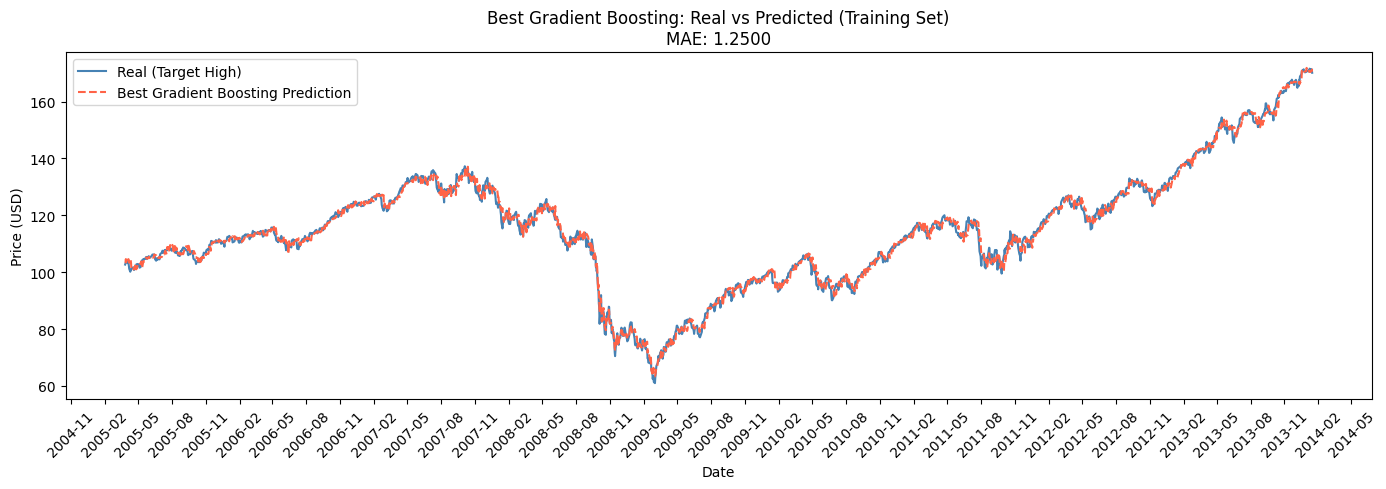

Plot saved as 'images/best_validation_predictions_gb.png'


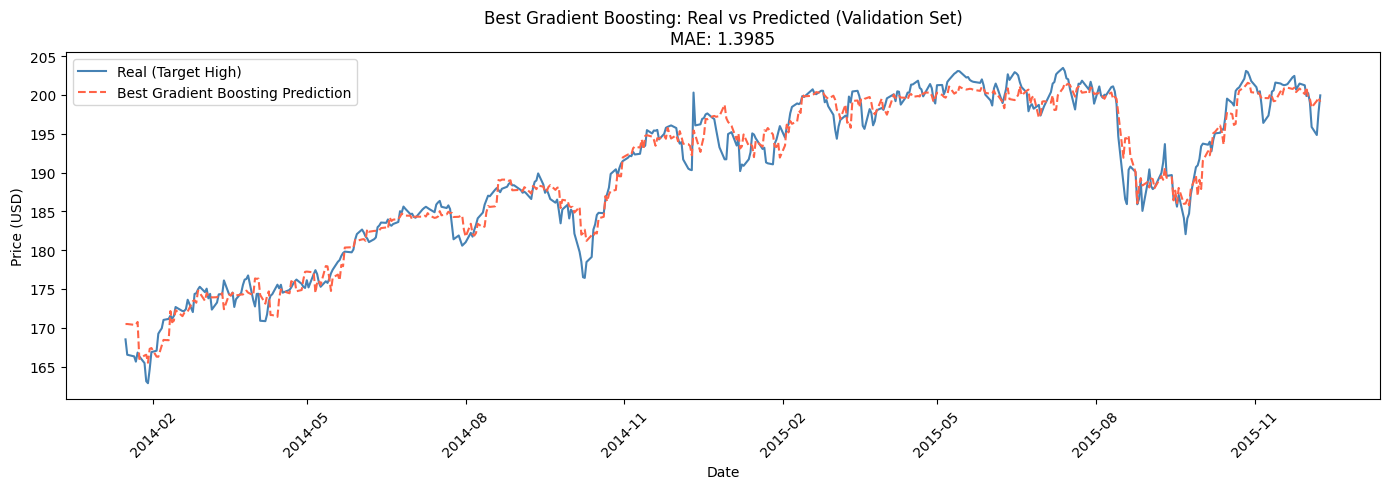

Plot saved as 'images/best_test_predictions_gb.png'


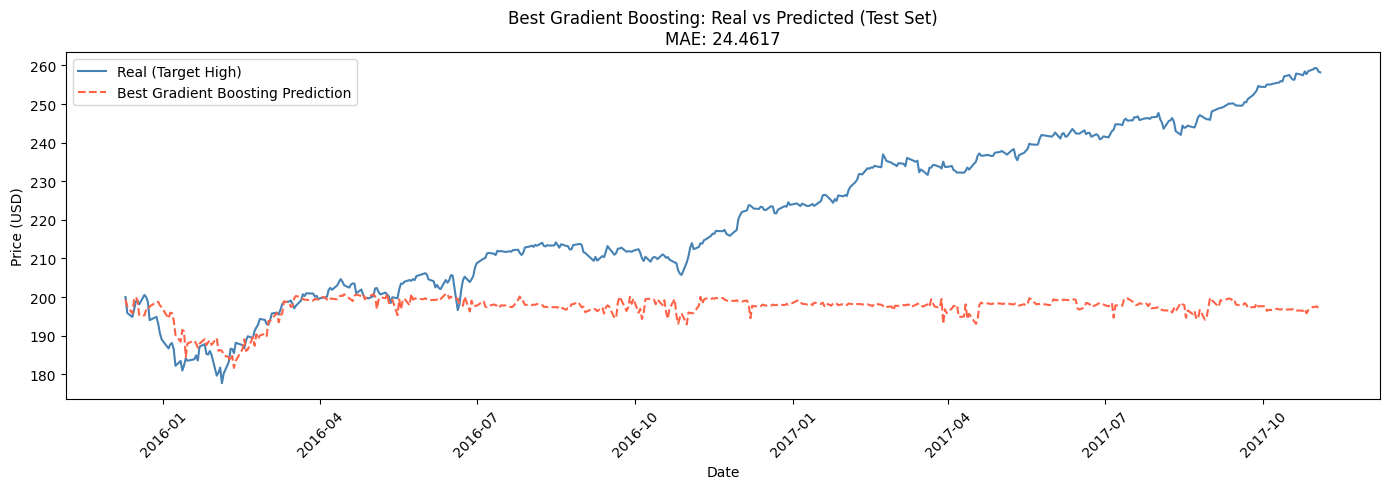

Best GBM -> Train MAE: 1.2500
Best GBM -> Val MAE:   1.3985
Best GBM -> Test MAE:  24.4617


In [18]:
best_gb = grid_search_gb.best_estimator_

mae_best_gb_train = plot_predictions(best_gb, X_train_scaled, y_train, df, 'Training',   'Best Gradient Boosting', filename=IMG_DIR + 'best_train_predictions_gb.png')
mae_best_gb_val   = plot_predictions(best_gb, X_val_scaled,   y_val,   df, 'Validation', 'Best Gradient Boosting', filename=IMG_DIR + 'best_validation_predictions_gb.png')
mae_best_gb_test  = plot_predictions(best_gb, X_test_scaled,  y_test,  df, 'Test',       'Best Gradient Boosting', filename=IMG_DIR + 'best_test_predictions_gb.png')

print(f"Best GBM -> Train MAE: {mae_best_gb_train:.4f}")
print(f"Best GBM -> Val MAE:   {mae_best_gb_val:.4f}")
print(f"Best GBM -> Test MAE:  {mae_best_gb_test:.4f}")

### Gradient Boosting: Results and Limitations

After optimizing the model, the grid search identified the best hyperparameter combination (e.g., `max_depth=3`, `learning_rate=0.05`, `n_estimators=100`).

**Analyzing the Test MAE and the "Flattening" Effect:**
Similar to the Random Forest model, the Gradient Boosting Regressor performs well on the validation set but its performance degrades noticeably on the test set. 

If you observe the final test prediction graph, the predicted line **flattens out** just as it did with the Random Forest. This highlights a universal limitation of standard decision-tree-based algorithms (including bagging and boosting methods): **the inability to extrapolate**. 

Because the underlying algorithm relies on splitting the feature space and averaging the targets within terminal leaf nodes, the model is mathematically bounded by the minimum and maximum target values it observed during the training window. As the SPY ETF continues its macroeconomic upward trend into the test period, the actual prices surpass the historical maximums. The Gradient Boosting model simply hits its ceiling and predicts a horizontal flatline, resulting in a widened MAE gap.

---

### Model 3: Multilayer Perceptron (MLP)

Our final batch model is a **Multilayer Perceptron (MLP)**, a class of feedforward artificial neural network. Unlike the previous tree-based ensemble methods, an MLP learns complex, non-linear mappings between inputs and outputs through interconnected layers of nodes (neurons) and activation functions.

**Scaling and Cross-Validation:**
Neural networks calculate gradients and are highly sensitive to the magnitude of input features, making the standardization step (e.g., `StandardScaler`) absolutely critical here. As with our previous models, we utilize the `PredefinedSplit` to strictly separate our temporal training and validation folds, ensuring no future data leaks into the training pipeline.

**Hyperparameter Tuning:**
Because MLPs are highly sensitive to their configuration, we put significant effort into tuning this architecture. Key parameters optimized include:
* **`hidden_layer_sizes`**: The depth and width of the network (number of layers and neurons per layer).
* **`activation`**: The mathematical function applied to the hidden nodes (e.g., ReLU, Tanh) to capture non-linear market patterns.
* **`alpha`**: The L2 penalty (regularization term) to prevent the network from overfitting to the noisy financial training data.
* **`learning_rate_init`** and **`max_iter`**: To govern how the optimizer navigates the gradient descent to find the global minimum error.

Bridge variables ready: X_tr=(2217, 8), X_vl=(479, 8), X_te=(480, 8)
Number of features: 8
MLP shapes: train=(2217, 8), val=(479, 8), test=(480, 8)


E0000 00:00:1772018319.066496    2884 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1772018319.077971    2884 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,897 (222.25 KB)

 Trainable params: 55,873 (218.25 KB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 111.6542 - val_loss: 185.9909
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87.6469 - val_loss: 132.3444
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.6645 - val_loss: 45.3455
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.9390 - val_loss: 30.2308
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.8496 - val_loss: 23.7406
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.3663 - val_loss: 12.1228
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.2666 - val_loss: 12.7684
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.0372 - val_loss: 14.9238
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.7705 - val_loss: 9.2823
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.5551 - val_loss: 13.2743
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.1012 - val_loss: 11.3177
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━━

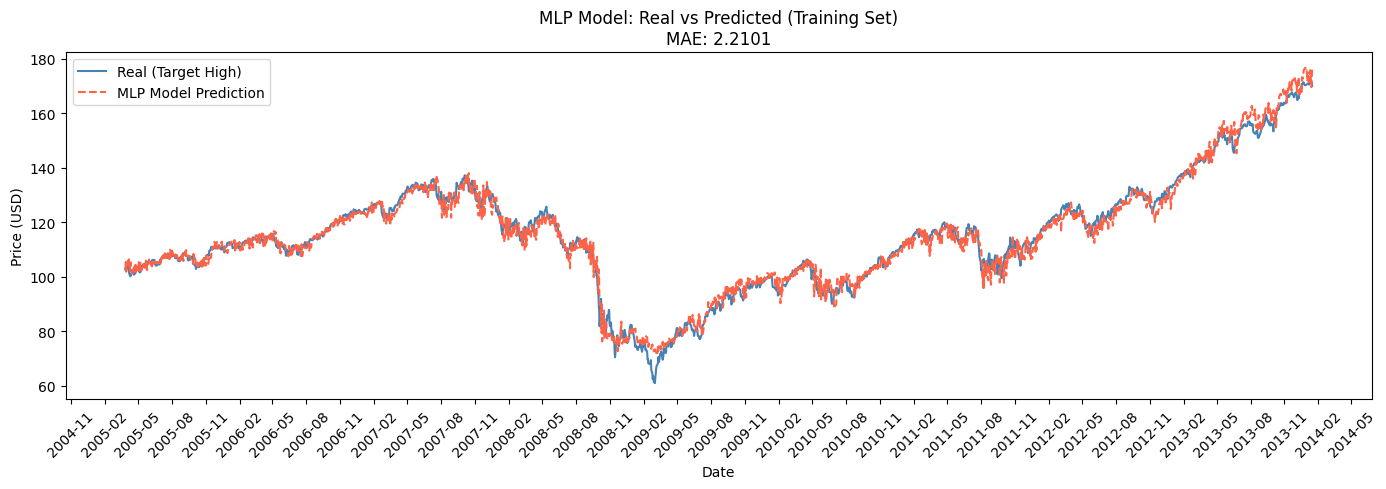

Plot saved as 'images/validation_predictions_mlp.png'


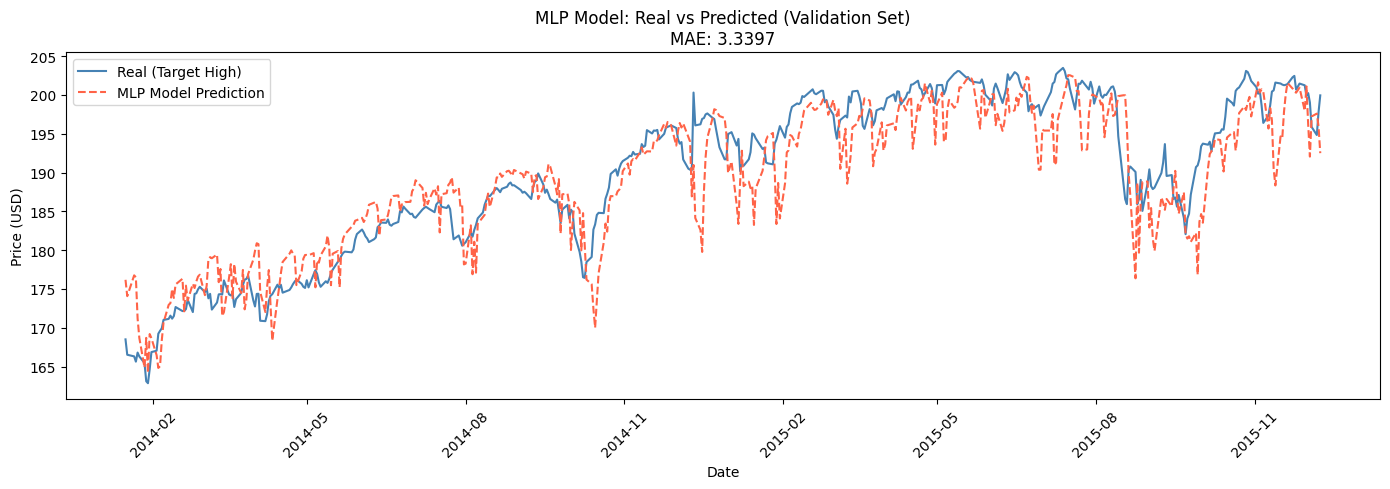

Plot saved as 'images/test_predictions_mlp.png'


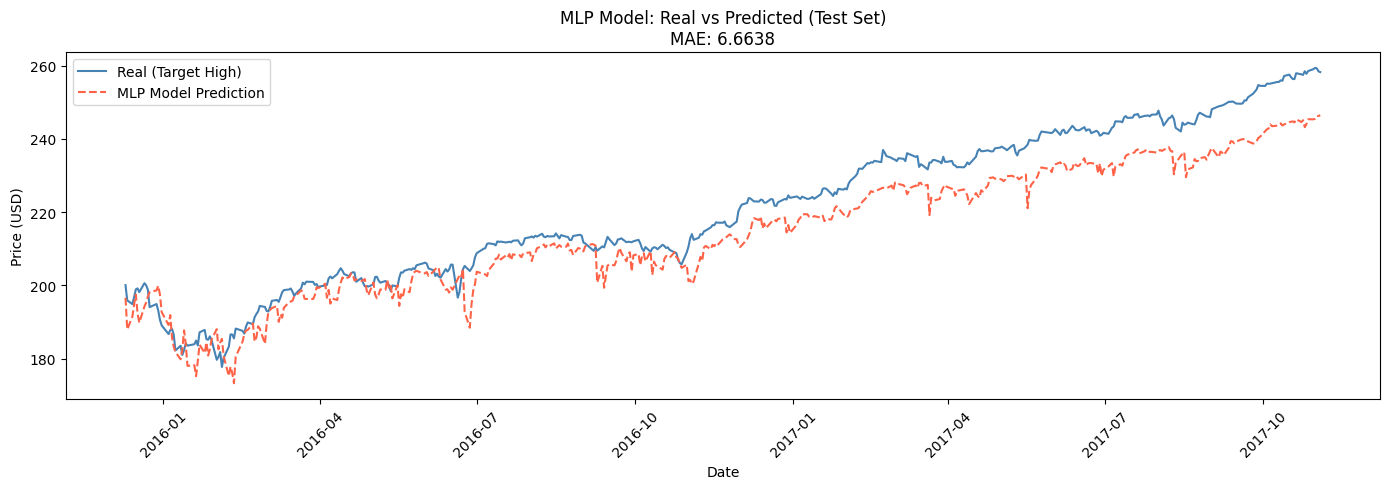

6.66381397857666

In [ ]:
n_features = X_train_scaled.shape[1]
print(f"Number of features: {n_features}")
print(f"MLP shapes: train={X_train_scaled.shape}, val={X_val_scaled.shape}, test={X_test_scaled.shape}")

# MLP Architecture
model_mlp = Sequential([
    Input(shape=(n_features,)),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),

    Dense(1)
])

model_mlp.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mae'
)

model_mlp.summary()

# Train with EarlyStopping
history_mlp = model_mlp.fit(
    X_train_scaled, y_train.values,
    validation_data=(X_val_scaled, y_val.values),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )],
    verbose=1
)

# Evaluate
y_pred_train_mlp = model_mlp.predict(X_train_scaled, verbose=0).flatten()
y_pred_val_mlp   = model_mlp.predict(X_val_scaled, verbose=0).flatten()
y_pred_test_mlp  = model_mlp.predict(X_test_scaled, verbose=0).flatten()

mae_train_mlp = mean_absolute_error(y_train.values, y_pred_train_mlp)
mae_val_mlp   = mean_absolute_error(y_val.values, y_pred_val_mlp)
mae_test_mlp  = mean_absolute_error(y_test.values, y_pred_test_mlp)

print(f"\n--- MLP Model ---")
print(f"Train MAE: {mae_train_mlp:.4f}")
print(f"Val   MAE: {mae_val_mlp:.4f}")
print(f"Test  MAE: {mae_test_mlp:.4f}")

# Plots
plot_predictions_LPM(y_train.values, y_pred_train_mlp, X_train.index, df, 'Training', 'MLP Model', filename=IMG_DIR + 'train_predictions_mlp.png')
plot_predictions_LPM(y_val.values, y_pred_val_mlp,   X_val.index,   df, 'Validation', 'MLP Model', filename=IMG_DIR + 'validation_predictions_mlp.png')
plot_predictions_LPM(y_test.values, y_pred_test_mlp,  X_test.index,  df, 'Test', 'MLP Model', filename=IMG_DIR + 'test_predictions_mlp.png')

Starting GridSearch for MLP...

--- Run 1/12 | layers=(64, 32), dropout=0.2, lr=0.001 ---
  Val MAE: 2.6811
--- Run 2/12 | layers=(64, 32), dropout=0.3, lr=0.0005 ---
  Val MAE: 2.9601
--- Run 3/12 | layers=(128, 64), dropout=0.2, lr=0.001 ---
  Val MAE: 2.8479
--- Run 4/12 | layers=(128, 64), dropout=0.3, lr=0.0005 ---
  Val MAE: 2.7899
--- Run 5/12 | layers=(128, 64), dropout=0.2, lr=0.0001 ---
  Val MAE: 145.6672
--- Run 6/12 | layers=(128, 64), dropout=0.3, lr=0.0001 ---
  Val MAE: 138.3923
--- Run 7/12 | layers=(128, 128, 64), dropout=0.2, lr=0.001 ---
  Val MAE: 2.3108
--- Run 8/12 | layers=(128, 128, 64), dropout=0.3, lr=0.0005 ---
  Val MAE: 3.1215
--- Run 9/12 | layers=(128, 128, 64), dropout=0.2, lr=0.0001 ---
  Val MAE: 139.9662
--- Run 10/12 | layers=(128, 128, 128, 128, 32), dropout=0.2, lr=0.001 ---
  Val MAE: 2.4757
--- Run 11/12 | layers=(128, 128, 128, 128, 32), dropout=0.3, lr=0.0005 ---
  Val MAE: 3.4567
--- Run 12/12 | layers=(128, 128, 128, 128, 32), dropout=0.3, l

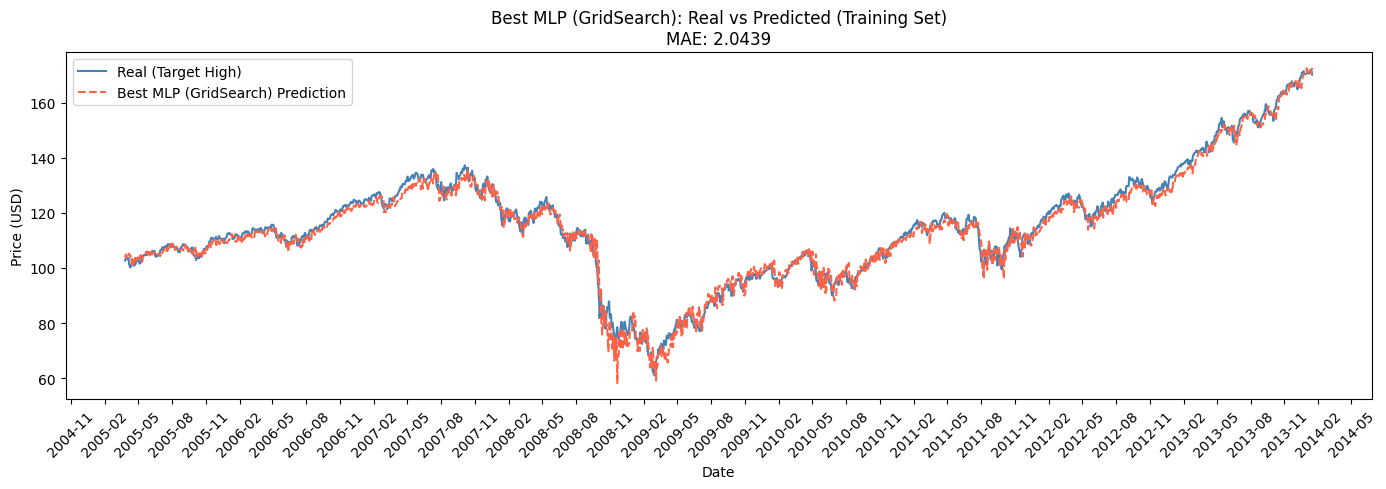

Plot saved as 'images/best_validation_predictions_mlp.png'


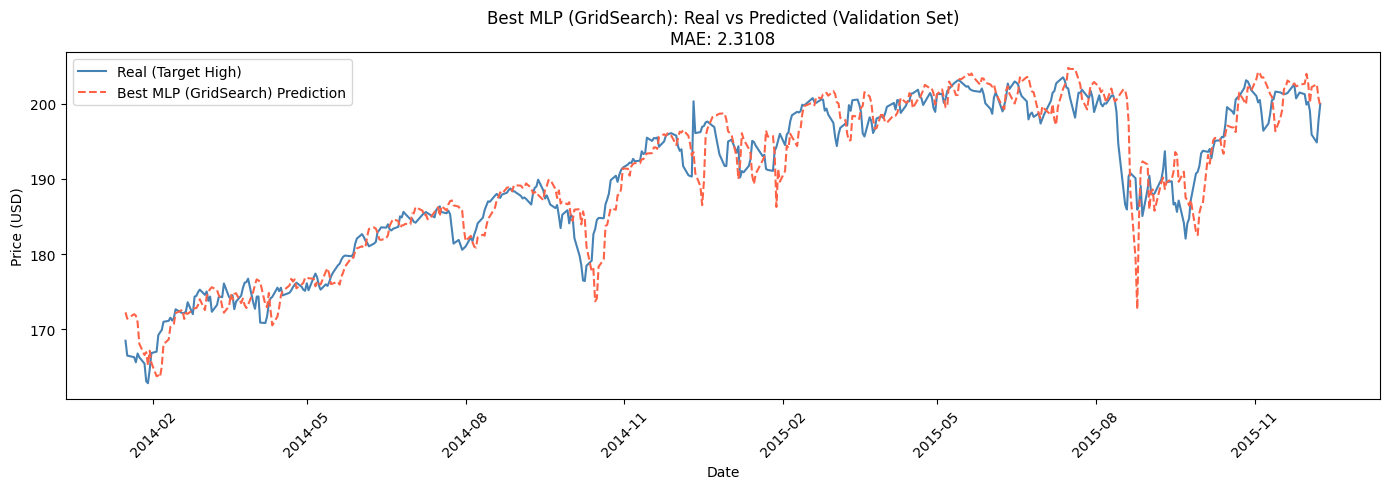

Plot saved as 'images/best_test_predictions_mlp.png'


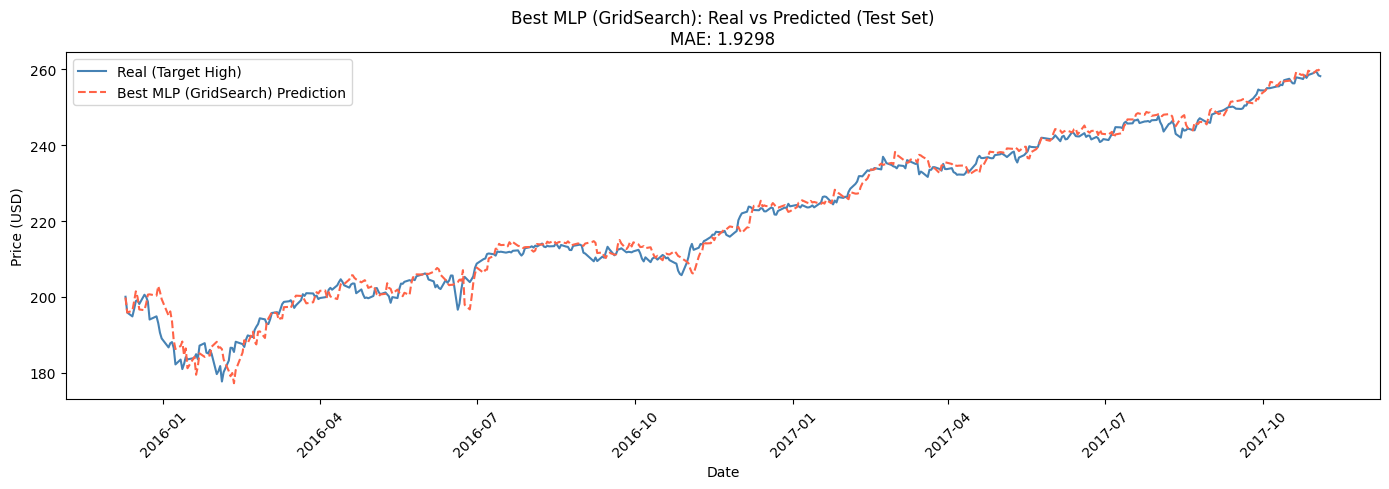

1.929847305552165

In [20]:
# GridSearch for MLP

def build_mlp(n_features, hidden_layers, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    for units in hidden_layers:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae')
    return model

# 12 configurations
configurations_mlp = [
    {'hidden_layers': (64, 32),                'dropout_rate': 0.2, 'learning_rate': 1e-3},
    {'hidden_layers': (64, 32),                'dropout_rate': 0.3, 'learning_rate': 5e-4},
    {'hidden_layers': (128, 64),               'dropout_rate': 0.2, 'learning_rate': 1e-3},
    {'hidden_layers': (128, 64),               'dropout_rate': 0.3, 'learning_rate': 5e-4},
    {'hidden_layers': (128, 64),               'dropout_rate': 0.2, 'learning_rate': 1e-4},
    {'hidden_layers': (128, 64),               'dropout_rate': 0.3, 'learning_rate': 1e-4},
    {'hidden_layers': (128, 128, 64),          'dropout_rate': 0.2, 'learning_rate': 1e-3},
    {'hidden_layers': (128, 128, 64),          'dropout_rate': 0.3, 'learning_rate': 5e-4},
    {'hidden_layers': (128, 128, 64),          'dropout_rate': 0.2, 'learning_rate': 1e-4},
    {'hidden_layers': (128, 128, 128, 128, 32),'dropout_rate': 0.2, 'learning_rate': 1e-3},
    {'hidden_layers': (128, 128, 128, 128, 32),'dropout_rate': 0.3, 'learning_rate': 5e-4},
    {'hidden_layers': (128, 128, 128, 128, 32),'dropout_rate': 0.3, 'learning_rate': 1e-4},
]

best_val_mae_mlp = float('inf')
best_config_mlp = None
best_mlp = None

print("Starting GridSearch for MLP...\n")

for run, config in enumerate(configurations_mlp, 1):
    print(f"--- Run {run}/{len(configurations_mlp)} | layers={config['hidden_layers']}, "
          f"dropout={config['dropout_rate']}, lr={config['learning_rate']} ---")

    tf.random.set_seed(SEED)
    np.random.seed(SEED)

    model = build_mlp(n_features, config['hidden_layers'], config['dropout_rate'], config['learning_rate'])

    model.fit(
        X_train_scaled, y_train.values,
        validation_data=(X_val_scaled, y_val.values),
        epochs=100,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)],
        verbose=0
    )

    y_pred_val = model.predict(X_val_scaled, verbose=0).flatten()
    current_val_mae = mean_absolute_error(y_val.values, y_pred_val)
    print(f"  Val MAE: {current_val_mae:.4f}")

    if current_val_mae < best_val_mae_mlp:
        best_val_mae_mlp = current_val_mae
        best_config_mlp = config
        best_mlp = model

# Best model results
print("\n" + "=" * 50)
print("BEST MLP MODEL FOUND")
print(f"Config: layers={best_config_mlp['hidden_layers']}, "
      f"dropout={best_config_mlp['dropout_rate']}, lr={best_config_mlp['learning_rate']}")
print("=" * 50)

y_pred_train_best = best_mlp.predict(X_train_scaled, verbose=0).flatten()
y_pred_val_best   = best_mlp.predict(X_val_scaled,   verbose=0).flatten()
y_pred_test_best  = best_mlp.predict(X_test_scaled,  verbose=0).flatten()

mae_best_mlp_train = mean_absolute_error(y_train.values, y_pred_train_best)
mae_best_mlp_val   = mean_absolute_error(y_val.values,   y_pred_val_best)
mae_best_mlp_test  = mean_absolute_error(y_test.values,  y_pred_test_best)

print(f"Best MLP -> Train MAE: {mae_best_mlp_train:.4f}")
print(f"Best MLP -> Val   MAE: {mae_best_mlp_val:.4f}")
print(f"Best MLP -> Test  MAE: {mae_best_mlp_test:.4f}")

plot_predictions_LPM(y_train.values, y_pred_train_best, X_train.index, df, 'Training',   'Best MLP (GridSearch)', filename=IMG_DIR + 'best_train_predictions_mlp.png')
plot_predictions_LPM(y_val.values,   y_pred_val_best,   X_val.index,   df, 'Validation', 'Best MLP (GridSearch)', filename=IMG_DIR + 'best_validation_predictions_mlp.png')
plot_predictions_LPM(y_test.values,  y_pred_test_best,  X_test.index,  df, 'Test',       'Best MLP (GridSearch)', filename=IMG_DIR + 'best_test_predictions_mlp.png')

### Multilayer Perceptron: Results and The Extrapolation Advantage

After an extensive grid search, the MLP emerged as our **best-performing model overall**, achieving the lowest Test MAE and outperforming both the tree-based batch models and the adaptive streaming models. 

**Overcoming the "Flattening" Effect:**
If you compare the test prediction graph of the MLP to the Random Forest or Gradient Boosting models, a stark difference is visible: **the MLP does not flatline.**

An MLP learns a continuous mathematical function (a combination of weights, inputs, and biases). Because the output layer applies a linear activation function, the network possesses the **ability to extrapolate**. 

When the SPY ETF entered uncharted macroeconomic highs during the test period, the tree models hit their historical ceiling and degraded. The MLP, conversely, used its learned feature weights to successfully project the upward trend into new price territories. This inherent capability to extrapolate is what allowed the batch MLP to secure the highest predictive accuracy in this analysis.

---

### Concept Drift Detection (batch models)

In this section, we will analyze the presence of concept drift in our trained batch models across both the validation and test sets. 

Because batch models are trained on a fixed historical dataset, their predictive power naturally degrades over time as market dynamics change. To monitor this, we implemented the `analyze_and_plot_drift_batch` function. This function sequentially compares the model's predictions against the actual target values to compute a chronological stream of absolute errors. 

We then apply two classic concept drift detection algorithms—**ADWIN** and **Page-Hinkley**—directly to this error stream to identify the exact moments when the model's performance significantly deteriorates. Finally, the function visualizes the error trend alongside the detected drift points.

We selected these specific detectors because they perfectly complement each other when analyzing noisy financial time series:

* **ADWIN (ADaptive WINdowing):** This algorithm dynamically adjusts a sliding window of recent errors. If the average error in a newer sub-window becomes significantly different from an older sub-window, it flags a drift. We chose ADWIN because it is highly robust and mathematically guaranteed to detect both **gradual degradation** in model performance and sudden shifts, all without requiring us to guess or hardcode a specific window size.
* **Page-Hinkley (PH):** This is a sequential analysis technique designed to detect sudden changes in the mean of a signal. By calculating the cumulative sum of the observed errors, PH is extremely sensitive to **sudden, sharp market shocks** (like unexpected macroeconomic news or crashes). We chose it because it flags the exact moment a model's error spikes abruptly, indicating an immediate need for retraining.

By tracking these drift points, we can understand precisely when our static batch models become obsolete and require retraining with fresh data.


--- Analyzing Concept Drift for Random Forest (Validation Set) ---
ADWIN detected 1 drift points.
Page-Hinkley detected 3 drift points.
Plot saved as 'images/validation_drift_rf.png'


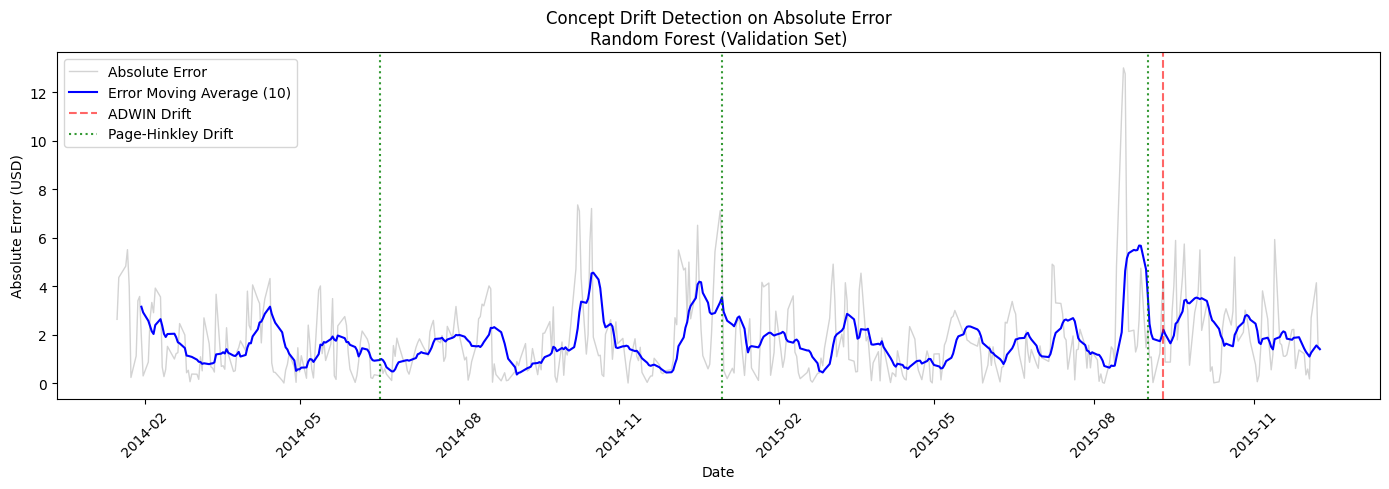


--- Analyzing Concept Drift for Random Forest (Test Set) ---
ADWIN detected 6 drift points.
Page-Hinkley detected 10 drift points.
Plot saved as 'images/test_drift_rf.png'


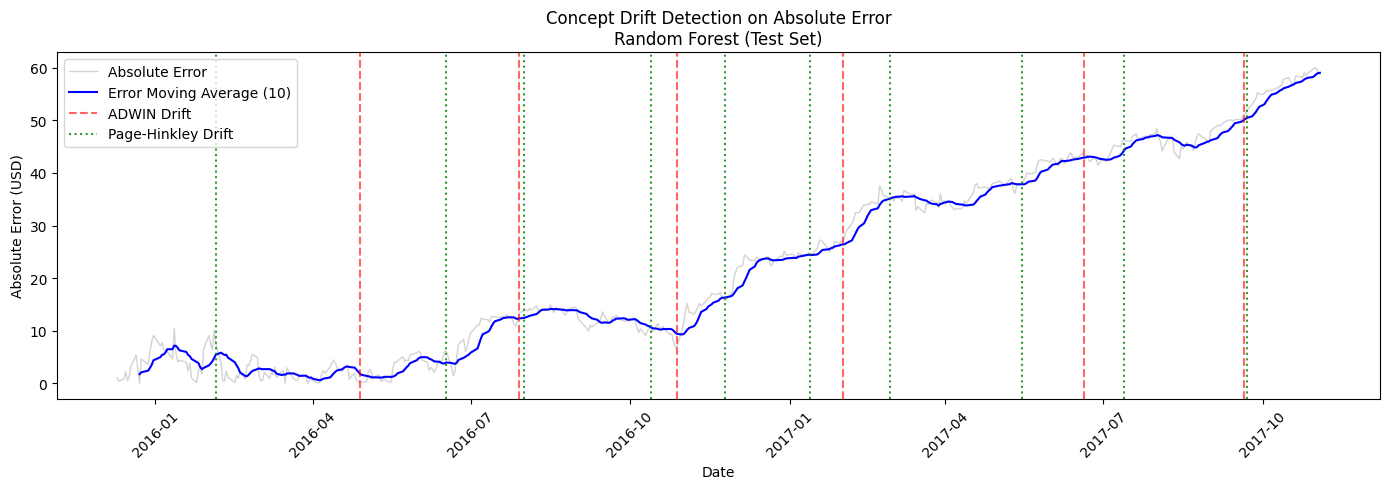

In [21]:
adwin_val_rf, ph_val_rf = analyze_and_plot_drift_batch(best_rf, X_val_scaled, y_val, df, 'Validation', 'Random Forest', filename=IMG_DIR + 'validation_drift_rf.png')
adwin_test_rf, ph_test_rf = analyze_and_plot_drift_batch(best_rf, X_test_scaled, y_test, df, 'Test', 'Random Forest', filename=IMG_DIR + 'test_drift_rf.png')


--- Analyzing Concept Drift for Gradient Boosting (Validation Set) ---
ADWIN detected 0 drift points.
Page-Hinkley detected 1 drift points.
Plot saved as 'images/validation_drift_gb.png'


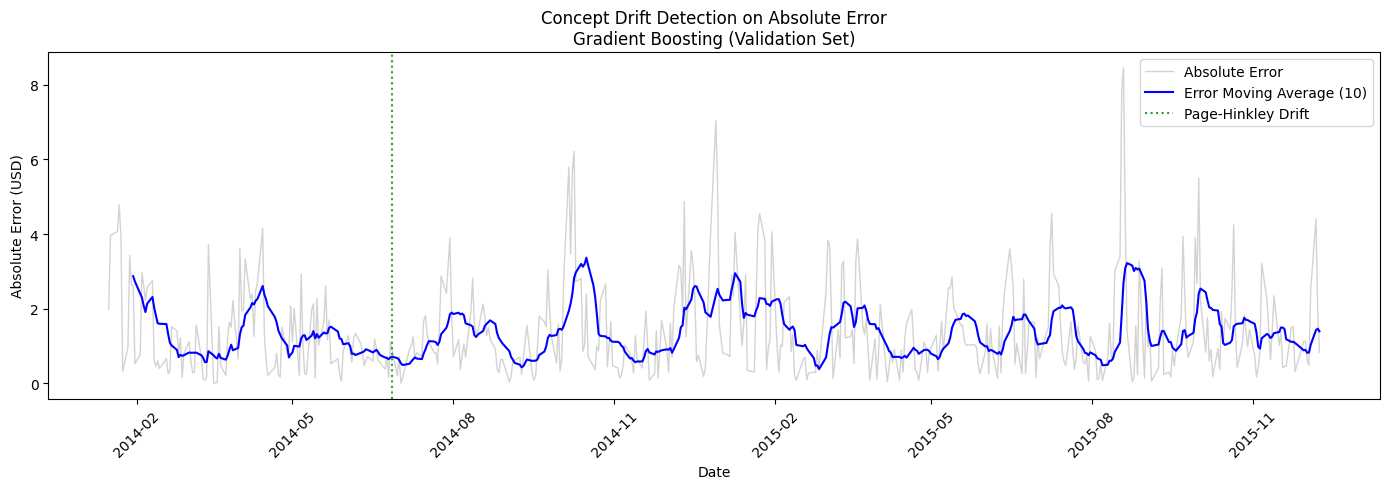


--- Analyzing Concept Drift for Gradient Boosting (Test Set) ---
ADWIN detected 5 drift points.
Page-Hinkley detected 10 drift points.
Plot saved as 'images/test_drift_gb.png'


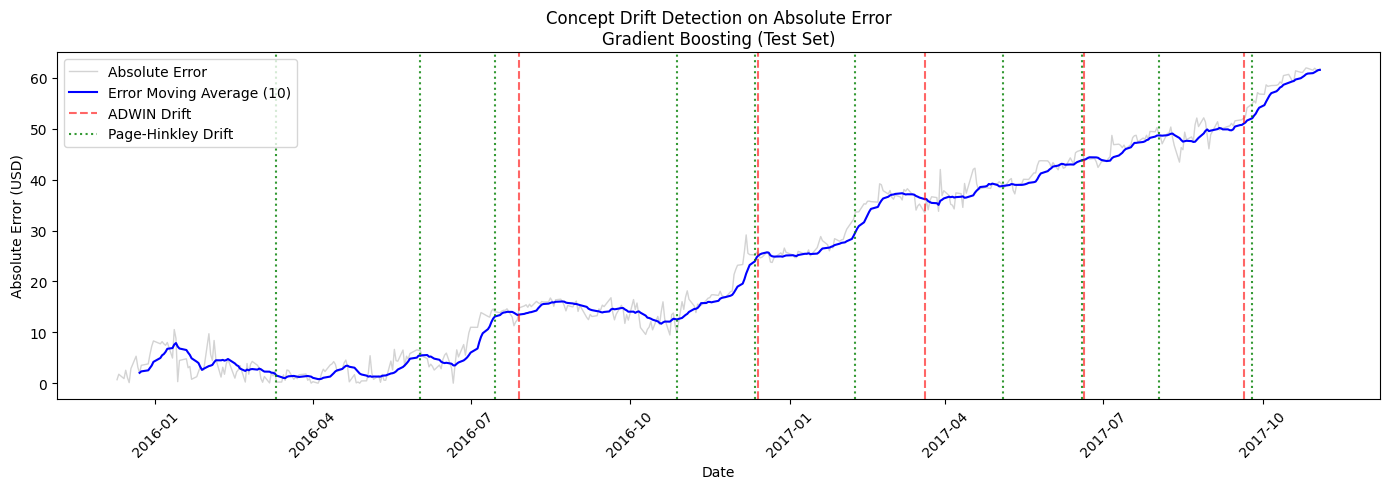

In [22]:
adwin_val_gb, ph_val_gb = analyze_and_plot_drift_batch(best_gb, X_val_scaled, y_val, df, 'Validation', 'Gradient Boosting', filename=IMG_DIR + 'validation_drift_gb.png')
adwin_test_gb, ph_test_gb = analyze_and_plot_drift_batch(best_gb, X_test_scaled, y_test, df, 'Test', 'Gradient Boosting', filename=IMG_DIR + 'test_drift_gb.png')


--- Analyzing Concept Drift for MLP (Validation Set) ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
ADWIN detected 2 drift points.
Page-Hinkley detected 6 drift points.
Plot saved as 'images/validation_drift_mlp.png'


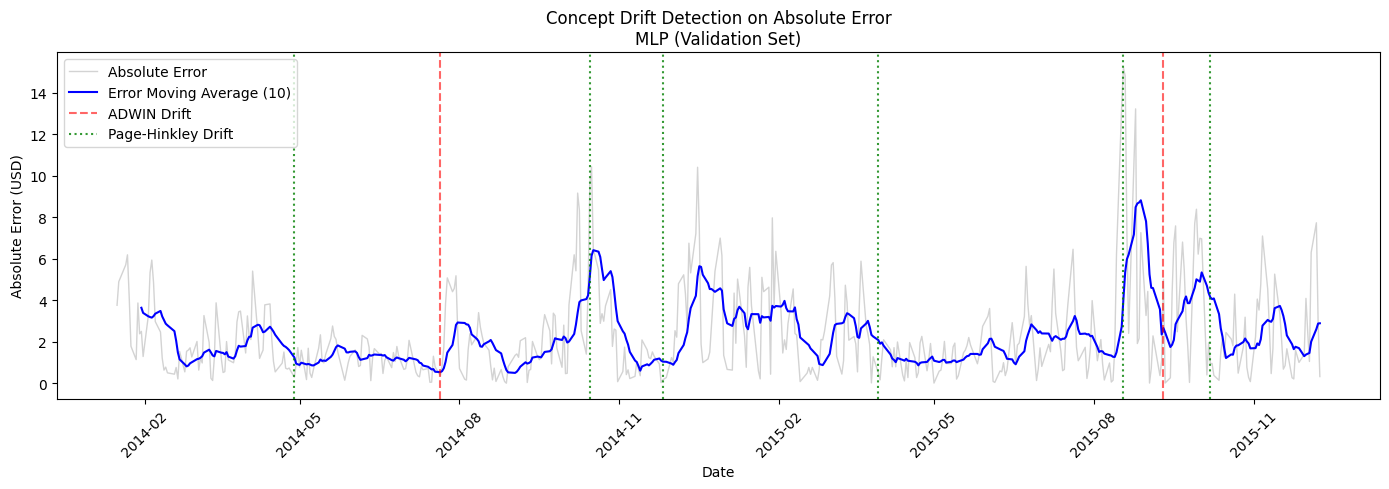


--- Analyzing Concept Drift for MLP (Test Set) ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
ADWIN detected 1 drift points.
Page-Hinkley detected 2 drift points.
Plot saved as 'images/test_drift_mlp.png'


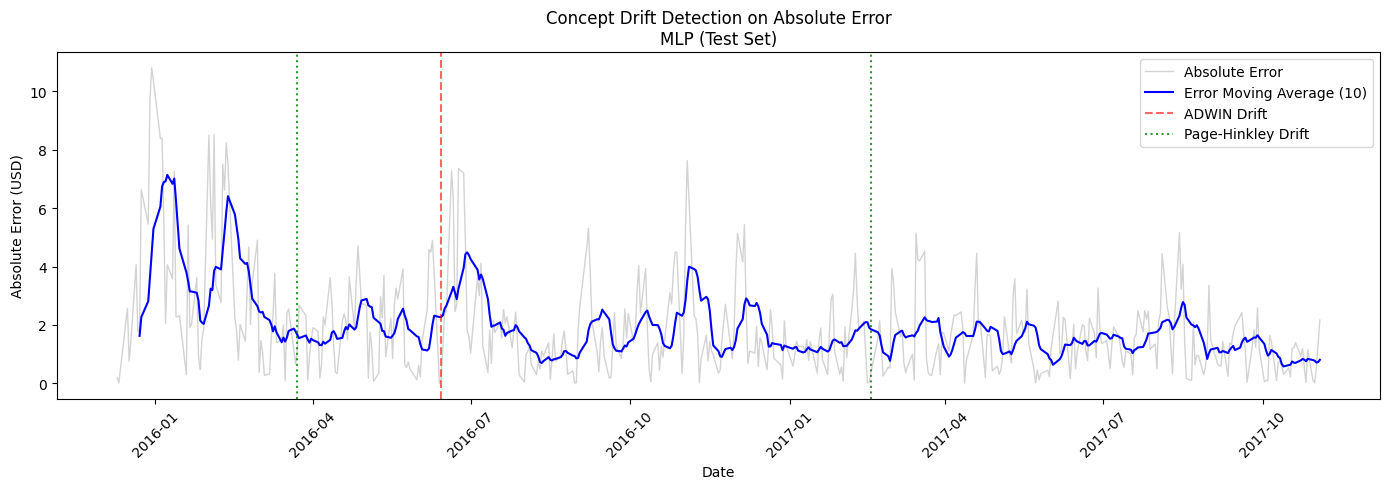

In [23]:
adwin_val_mlp, ph_val_mlp = analyze_and_plot_drift_batch(best_mlp, X_val_scaled, y_val, df, 'Validation', 'MLP', filename=IMG_DIR + 'validation_drift_mlp.png')
adwin_test_mlp, ph_test_mlp = analyze_and_plot_drift_batch(best_mlp, X_test_scaled, y_test, df, 'Test', 'MLP', filename=IMG_DIR + 'test_drift_mlp.png')

### Analyzing Concept Drift in Batch Models

The charts above visualize the **Absolute Error** of our batch models over time, overlaid with the exact timestamps where our two drift detectors (ADWIN and Page-Hinkley) triggered an alert. 

**Interpreting the Detectors:**
* **The Error Trend:** The blue line represents the moving average of the absolute error. As we progress further away from the training data's timeline, the error steadily climbs. 
* **ADWIN (Red Dashed Lines):** ADWIN (Adaptive Windowing) dynamically adjusts a window of recent error values and compares it to older windows. When it detects a statistically significant difference in the mean error, it triggers a drift alert. These points indicate a clear, sustained degradation in model performance.
* **Page-Hinkley (Green Dotted Lines):** The Page-Hinkley test is designed to detect sudden, cumulative changes in the mean of a sequential signal. It often triggers rapidly during periods of high market volatility where the model's predictions suddenly deviate wildly from the actual prices.

**Why does this happen? (The Non-Stationarity Problem)**
Financial markets are fundamentally non-stationary. A static batch model assumes that the mapping between the features (e.g., historical returns, moving averages, volume) and the target variable (next day's high price) remains constant over time. 

However, in the real world, this relationship is constantly shifting due to macroeconomic changes, interest rate hikes, corporate earnings, and global news events. The batch models are heavily optimized for the specific market conditions present in the training set. When those conditions inevitably change in the validation and test sets, the static rules the models learned become obsolete. 

**Conclusion on Batch Learning:**
The frequent drift alerts detected by both ADWIN and Page-Hinkley serve as mathematical proof that deploying a static batch model for stock price prediction is risky. Without a mechanism to continuously update its internal weights and unlearn outdated patterns, a batch model's accuracy will always degrade over time. This explicitly motivates our transition to **Stream Learning models**, which are designed to continuously adapt to these underlying market shifts.

-----

## Online Learning

### Model 4: Hoeffding Tree Regressor

Our first stream model is the **Hoeffding Tree Regressor**. It is the online equivalent of a standard Decision Tree Regressor, but designed to process infinite data streams without storing the data in memory.

**How it works:**
A traditional decision tree needs to see all the training data at once to calculate the optimal feature and threshold for splitting a node. A Hoeffding Tree, however, uses a statistical theorem called the **Hoeffding Bound**. This bound mathematically guarantees that after seeing a sufficient number of streaming samples, the feature chosen for a split will be the exact same feature a batch decision tree would have chosen, with high probability. 

As the SPY ETF stream flows in, the tree incrementally updates the statistics at its leaf nodes and dynamically grows new branches when it accumulates enough evidence of a new market pattern.

Starting Hyperparameter Tuning for Online Hoeffding Adaptive Tree...

--- Run 1/5 | Config: {'grace_period': 50, 'model_selector_decay': 0.9} ---
Result -> Val MAE: 3.5810 | Test MAE: 2.8285

--- Run 2/5 | Config: {'grace_period': 50, 'model_selector_decay': 0.95} ---
Result -> Val MAE: 3.4662 | Test MAE: 4.4865

--- Run 3/5 | Config: {'grace_period': 100, 'model_selector_decay': 0.9} ---
Result -> Val MAE: 4.4113 | Test MAE: 2.8554

--- Run 4/5 | Config: {'grace_period': 100, 'model_selector_decay': 0.99} ---
Result -> Val MAE: 6.1728 | Test MAE: 7.0071

--- Run 5/5 | Config: {'grace_period': 200, 'model_selector_decay': 0.95} ---
Result -> Val MAE: 3.0484 | Test MAE: 2.3695

BEST MODEL FOUND
Configuration : {'grace_period': 200, 'model_selector_decay': 0.95}
Validation MAE: 3.0484
Test MAE      : 2.3695
Plot saved as 'images/best_validation_predictions_hoef.png'


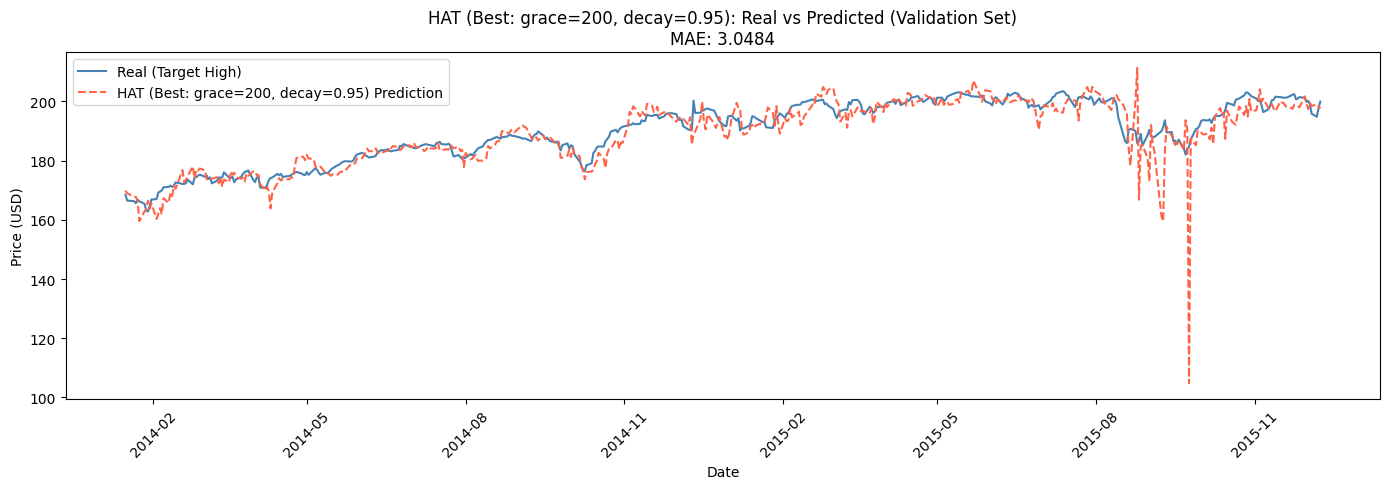

Plot saved as 'images/best_test_predictions_hoef.png'


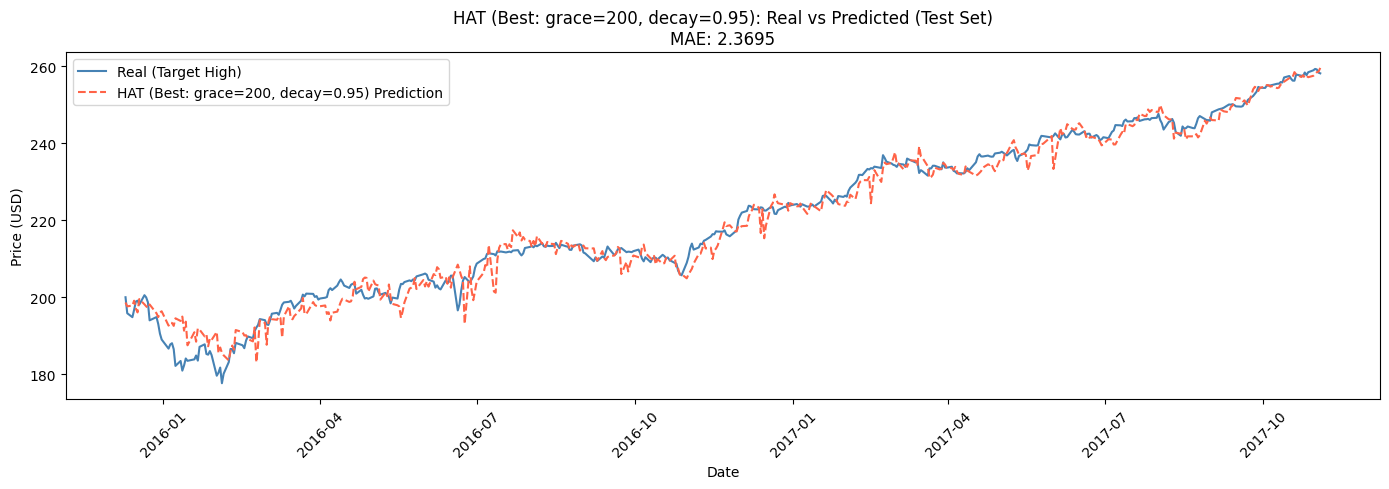

In [24]:
# 1. Define 5 hyperparameter configurations to test for Hoeffding Adaptive Tree
# grace_period: Number of instances a leaf must observe before attempting a split
# model_selector_decay: Decay factor for evaluating if an alternative branch is better than the current one
configurations_hoef = [
    {'grace_period': 50,  'model_selector_decay': 0.9},   # Fast growth, quick adaptation
    {'grace_period': 50,  'model_selector_decay': 0.95},  # Fast growth, slightly slower adaptation
    {'grace_period': 100, 'model_selector_decay': 0.9},   # Medium growth, quick adaptation
    {'grace_period': 100, 'model_selector_decay': 0.99},  # Medium growth, very stable adaptation
    {'grace_period': 200, 'model_selector_decay': 0.95}   # Slow/Stable growth, moderate adaptation
]

# Variables to keep track of the best model
best_val_mae_hoef = float('inf')
best_config_hoef = None
best_test_mae_hoef = None
best_records_val_hoef = []
best_records_test_hoef = []

print("Starting Hyperparameter Tuning for Online Hoeffding Adaptive Tree...\n")

# 2. Loop through each configuration
for run, config in enumerate(configurations_hoef, 1):
    print(f"--- Run {run}/5 | Config: {config} ---")
    
    # We MUST recreate the pipeline from scratch for each run 
    # to prevent the tree from carrying over memory/growth from the previous run.
    river_model_hoef = compose.Pipeline(
        OnlineSPYFeatures(),
        preprocessing.StandardScaler(),  # Scales the data (standarization) to avoid inestability
        tree.HoeffdingAdaptiveTreeRegressor(
            grace_period=config['grace_period'],
            model_selector_decay=config['model_selector_decay'],
            seed=SEED
        )
    )

    # Initialize fresh metrics and lists for this run
    metric_val_hoef  = metrics.MAE()
    metric_test_hoef = metrics.MAE()
    records_val_hoef  = []
    records_test_hoef = []

    # 3. Training Loop (Test-then-Train)
    for index, row in df.iterrows():
        x = row[['Open', 'High', 'Low', 'Close', 'Volume']].to_dict()
        y = row['Target_High']
        
        # PREDICTION
        y_pred = river_model_hoef.predict_one(x)
        
        # UPDATE METRICS
        if index in X_val.index:
            metric_val_hoef.update(y, y_pred)
            records_val_hoef.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        elif index in X_test.index:
            metric_test_hoef.update(y, y_pred)
            records_test_hoef.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        # LEARNING
        river_model_hoef.learn_one(x, y)

    # Current run results
    current_val_mae = metric_val_hoef.get()
    current_test_mae = metric_test_hoef.get()
    print(f"Result -> Val MAE: {current_val_mae:.4f} | Test MAE: {current_test_mae:.4f}\n")

    # 4. Check if this is the best model so far (based on Validation MAE)
    if current_val_mae < best_val_mae_hoef:
        best_val_mae_hoef = current_val_mae
        best_config_hoef = config
        best_test_mae_hoef = current_test_mae
        
        # Save the records of the best execution for later plotting
        best_records_val_hoef = records_val_hoef
        best_records_test_hoef = records_test_hoef

# 5. Final Results & Plotting
print("="*50)
print("BEST MODEL FOUND")
print(f"Configuration : {best_config_hoef}")
print(f"Validation MAE: {best_val_mae_hoef:.4f}")
print(f"Test MAE      : {best_test_mae_hoef:.4f}")
print("="*50)

# Plot using the records from the best configuration
plot_title = f"HAT (Best: grace={best_config_hoef['grace_period']}, decay={best_config_hoef['model_selector_decay']})"
mae_hat_val = plot_predictions_online(best_records_val_hoef, 'Validation', plot_title, filename=IMG_DIR + 'best_validation_predictions_hoef.png')
mae_hat_test = plot_predictions_online(best_records_test_hoef, 'Test', plot_title, filename=IMG_DIR + 'best_test_predictions_hoef.png')

### Hoeffding Tree: Results and Adaptability

Comparing the Hoeffding Tree's prediction graph to our earlier batch Random Forest reveals a crucial difference: **the Hoeffding tree does not permanently flatline.**

Because the model continuously updates itself with each new daily observation (`learn_one`), it learns the new, higher price ranges as the SPY ETF trends upward. While a batch decision tree hits a hard ceiling based on its static training set, the Hoeffding Tree dynamically adjusts its leaves and splits to accommodate the newly observed target values.

**Limitations:**
While it adapts much better than a static model, a single decision tree can still be quite noisy and sensitive to sudden daily spikes in the market. The predictions may occasionally lag behind sudden market shifts because the tree requires a certain amount of accumulated evidence (governed by the `grace_period` and Hoeffding bound parameters) before it confidently restructures its branches.

---

### KNN regressor

K-Nearest Neighbors (KNN) is a promising model for time series forecasting because it identifies historical patterns that closely resemble current conditions. In this approach, we configure the model to find the 5 closest historical days (neighbors) to inform its current prediction.

To optimize performance and relevance, we restricted the search engine's memory to retain only the last 30 observed instances (approximately one trading month). This not only makes the model computationally more efficient by reducing the memory footprint, but it also prevents the algorithm from conflating current market behaviors with similar but contextually outdated situations from distant time periods.

Furthermore, we aggregate the targets of these 5 neighbors using the median rather than the mean. This ensures our predictions remain robust and are not disproportionately skewed by outliers or extreme, anomalous market fluctuations.

Starting Hyperparameter Tuning for Online KNN Regressor...

--- Run 1/5 | Config: {'n_neighbors': 3, 'window_size': 30, 'aggregation_method': 'median'} ---
Result -> Val MAE: 2.4790 | Test MAE: 2.8246

--- Run 2/5 | Config: {'n_neighbors': 5, 'window_size': 30, 'aggregation_method': 'median'} ---
Result -> Val MAE: 2.4241 | Test MAE: 2.9291

--- Run 3/5 | Config: {'n_neighbors': 5, 'window_size': 60, 'aggregation_method': 'median'} ---
Result -> Val MAE: 3.4458 | Test MAE: 4.3649

--- Run 4/5 | Config: {'n_neighbors': 7, 'window_size': 90, 'aggregation_method': 'mean'} ---
Result -> Val MAE: 4.1810 | Test MAE: 5.5038

--- Run 5/5 | Config: {'n_neighbors': 10, 'window_size': 30, 'aggregation_method': 'mean'} ---
Result -> Val MAE: 2.5643 | Test MAE: 3.1711

BEST MODEL FOUND
Configuration : {'n_neighbors': 5, 'window_size': 30, 'aggregation_method': 'median'}
Validation MAE: 2.4241
Test MAE      : 2.9291
Plot saved as 'images/best_validation_predictions_knn.png'


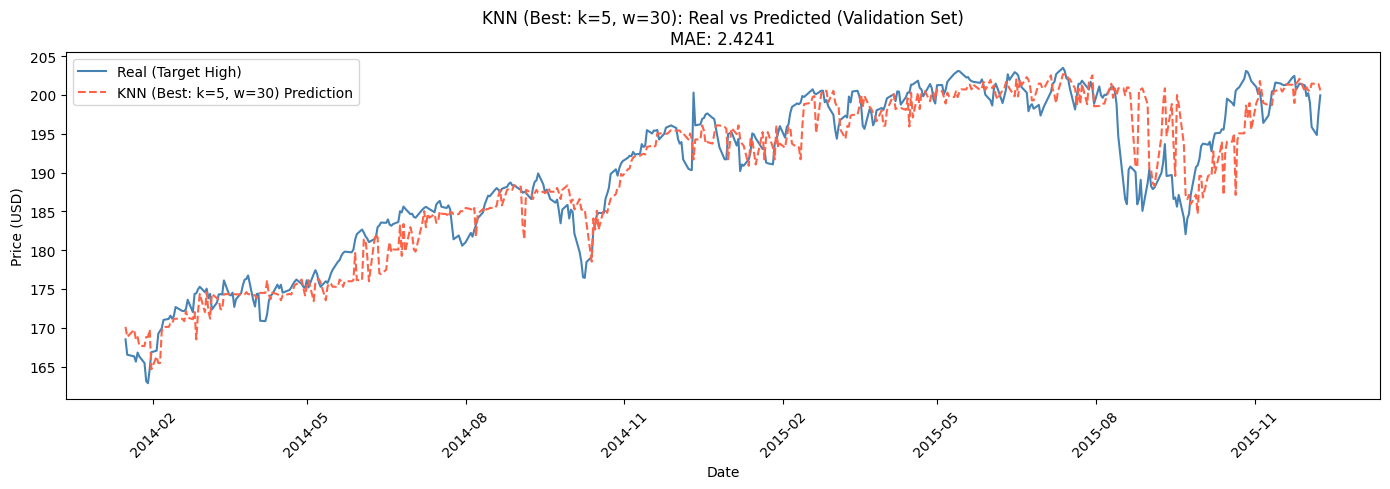

Plot saved as 'images/best_test_predictions_knn.png'


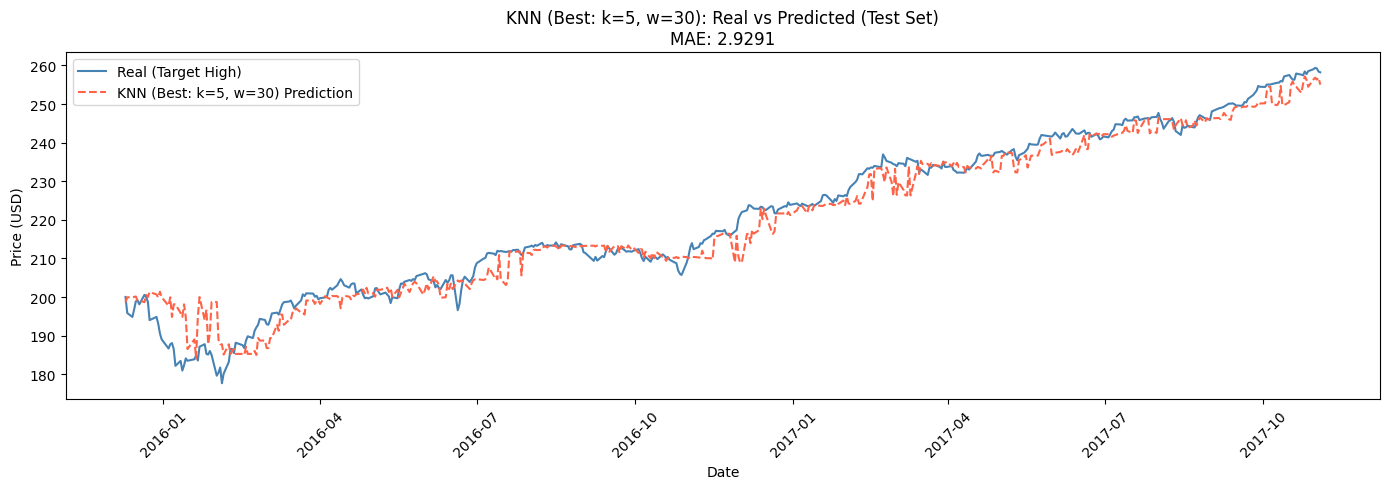

In [25]:
# 1. Define 5 hyperparameter configurations to test
configurations_knn = [
    {'n_neighbors': 3, 'window_size': 30, 'aggregation_method': 'median'},
    {'n_neighbors': 5, 'window_size': 30, 'aggregation_method': 'median'},
    {'n_neighbors': 5, 'window_size': 60, 'aggregation_method': 'median'}, # 2 months memory
    {'n_neighbors': 7, 'window_size': 90, 'aggregation_method': 'mean'},   # 3 months memory
    {'n_neighbors': 10, 'window_size': 30, 'aggregation_method': 'mean'}
]

# Variables to keep track of the best model
best_val_mae_knn = float('inf')
best_config_knn = None
best_test_mae_knn = None
best_records_val_knn = []
best_records_test_knn = []

print("Starting Hyperparameter Tuning for Online KNN Regressor...\n")

# 2. Loop through each configuration
for run, config in enumerate(configurations_knn, 1):
    print(f"--- Run {run}/5 | Config: {config} ---")
    
    # We MUST recreate the pipeline from scratch for each run 
    # to avoid mixing memory between different executions.
    river_model_knn = compose.Pipeline(
        OnlineSPYFeatures(),
        preprocessing.StandardScaler(), 
        neighbors.KNNRegressor(
            n_neighbors=config['n_neighbors'],
            engine=neighbors.LazySearch(window_size=config['window_size']),
            aggregation_method=config['aggregation_method']
        )
    )

    # Initialize fresh metrics and lists for this run
    metric_val_knn  = metrics.MAE()
    metric_test_knn = metrics.MAE()
    records_val_knn  = []
    records_test_knn = []

    # 3. Training Loop (Test-then-Train)
    for index, row in df.iterrows():
        x = row[['Open', 'High', 'Low', 'Close', 'Volume']].to_dict()
        y = row['Target_High']
        
        # PREDICTION
        y_pred = river_model_knn.predict_one(x)
        
        # UPDATE METRICS
        if index in X_val.index:
            metric_val_knn.update(y, y_pred)
            records_val_knn.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        elif index in X_test.index:
            metric_test_knn.update(y, y_pred)
            records_test_knn.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        # LEARNING
        river_model_knn.learn_one(x, y)

    # Current run results
    current_val_mae = metric_val_knn.get()
    current_test_mae = metric_test_knn.get()
    print(f"Result -> Val MAE: {current_val_mae:.4f} | Test MAE: {current_test_mae:.4f}\n")

    # 4. Check if this is the best model so far (based on Validation MAE)
    if current_val_mae < best_val_mae_knn:
        best_val_mae_knn = current_val_mae
        best_config_knn = config
        best_test_mae_knn = current_test_mae
        
        # Save the records of the best execution for later plotting
        best_records_val_knn = records_val_knn
        best_records_test_knn = records_test_knn

# 5. Final Results & Plotting
print("="*50)
print("BEST MODEL FOUND")
print(f"Configuration : {best_config_knn}")
print(f"Validation MAE: {best_val_mae_knn:.4f}")
print(f"Test MAE      : {best_test_mae_knn:.4f}")
print("="*50)

# Plot using the records from the best configuration
mae_knn_val = plot_predictions_online(best_records_val_knn, 'Validation', f"KNN (Best: k={best_config_knn['n_neighbors']}, w={best_config_knn['window_size']})", filename=IMG_DIR + 'best_validation_predictions_knn.png')
mae_knn_test = plot_predictions_online(best_records_test_knn, 'Test', f"KNN (Best: k={best_config_knn['n_neighbors']}, w={best_config_knn['window_size']})", filename=IMG_DIR + 'best_test_predictions_knn.png')

### Linear Regression

Online Linear Regression is a fundamental yet highly effective algorithm for data streams. Unlike traditional batch linear regression, which calculates a closed-form mathematical solution using the entire historical dataset, the online version relies on optimization algorithms like Stochastic Gradient Descent (SGD) to continuously update its weights step-by-step.

- Stochastic Gradient Descent (SGD) & Adam: The model processes one instance at a time, calculates the prediction error, and instantly adjusts the feature weights to minimize that error. The optimizer (such as SGD or Adam) and its learning rate determine how drastically the model changes its beliefs with each new data point.

- L2 Regularization (Ridge): To prevent the model from overfitting or assigning extremely large weights to noisy financial features, we can apply an L2 regularization penalty. This forces the model to keep its weights as small and stable as possible.

- Strict Scaling Requirement: Unlike tree-based models, gradient-based linear models are extremely sensitive to the magnitude of the input features. If a feature like 'Volume' is in the millions and 'Return' is in the decimals, the gradient will explode, and the model will fail to converge. Therefore, integrating a StandardScaler in the pipeline is strictly mandatory for this model to function correctly.

Starting Hyperparameter Tuning for Online Linear Regression...

--- Run 1/5 | Opt: SGD(lr=0.01), L2: 0.0 ---
Result -> Val MAE: 21.2307 | Test MAE: 17.1157

--- Run 2/5 | Opt: SGD(lr=0.001), L2: 0.1 ---
Result -> Val MAE: 3.4016 | Test MAE: 3.6302

--- Run 3/5 | Opt: SGD(lr=0.005), L2: 0.01 ---
Result -> Val MAE: 2.4245 | Test MAE: 2.0933

--- Run 4/5 | Opt: Adam(lr=0.01), L2: 0.0 ---
Result -> Val MAE: 3.7706 | Test MAE: 4.4739

--- Run 5/5 | Opt: Adam(lr=0.001), L2: 0.1 ---
Result -> Val MAE: 4.6696 | Test MAE: 6.5274

BEST MODEL FOUND
Configuration : Optimizer: SGD(lr=0.005), L2: 0.01
Validation MAE: 2.4245
Test MAE      : 2.0933
Plot saved as 'images/best_validation_predictions_lr.png'


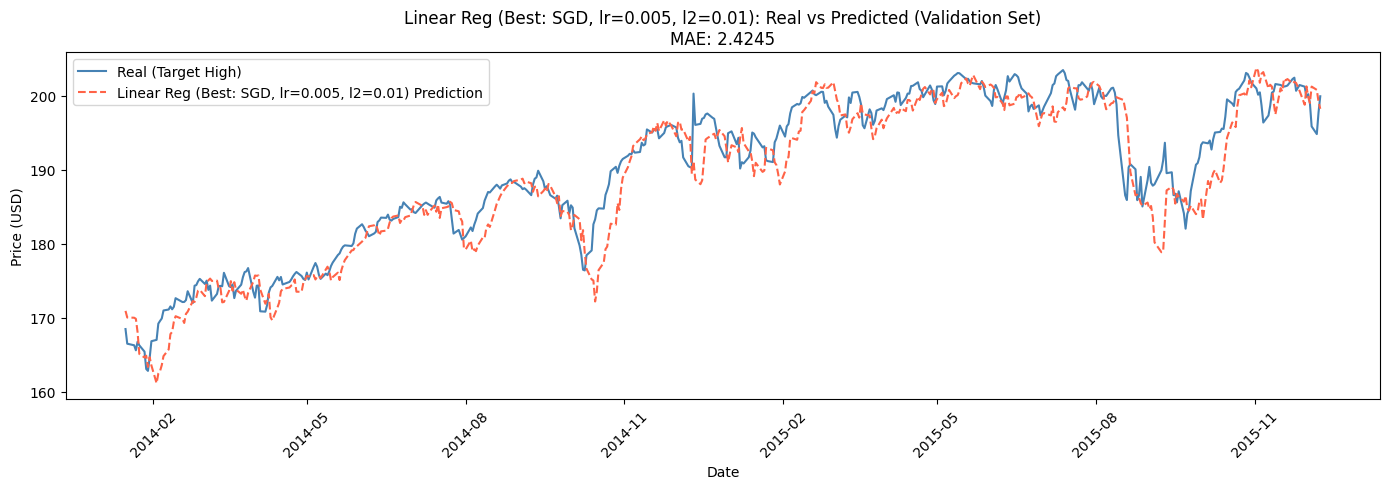

Plot saved as 'images/best_test_predictions_lr.png'


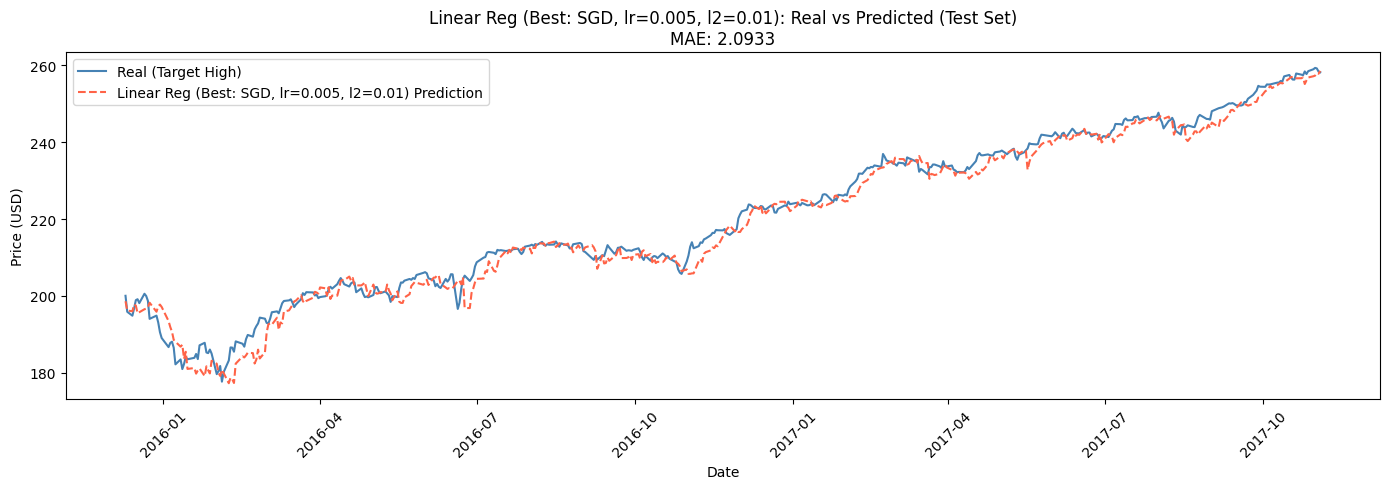

In [26]:
# 1. Define 5 hyperparameter configurations to test for Linear Regression
# optimizer: The optimization algorithm (SGD or Adam) and its Learning Rate (lr)
# l2: Regularization penalty to prevent overfitting (equivalent to Ridge Regression)
configurations_lr = [
    {'optimizer': optim.SGD(lr=0.01),   'l2': 0.0},    # Fast SGD, no regularization
    {'optimizer': optim.SGD(lr=0.001),  'l2': 0.1},    # Slow SGD, medium regularization
    {'optimizer': optim.SGD(lr=0.005),  'l2': 0.01},   # Moderate SGD, light regularization
    {'optimizer': optim.Adam(lr=0.01),  'l2': 0.0},    # Adam optimizer (adapts lr per feature)
    {'optimizer': optim.Adam(lr=0.001), 'l2': 0.1}     # Adam optimizer with regularization
]

# Variables to keep track of the best model
best_val_mae_lr = float('inf')
best_config_lr = None
best_test_mae_lr = None
best_records_val_lr = []
best_records_test_lr = []

print("Starting Hyperparameter Tuning for Online Linear Regression...\n")

# 2. Loop through each configuration
for run, config in enumerate(configurations_lr, 1):
    # Print the config name nicely since optimizer objects look messy when printed
    opt_name = config['optimizer'].__class__.__name__
    opt_lr = config['optimizer'].learning_rate
    print(f"--- Run {run}/5 | Opt: {opt_name}(lr={opt_lr}), L2: {config['l2']} ---")
    
    # We MUST recreate the pipeline from scratch for each run 
    # NOTICE: preprocessing.StandardScaler() is BACK. It is MANDATORY for Linear Models.
    river_model_lr = compose.Pipeline(
        OnlineSPYFeatures(),
        preprocessing.StandardScaler(), 
        linear_model.LinearRegression(
            optimizer=config['optimizer'],
            l2=config['l2']
        )
    )

    # Initialize fresh metrics and lists for this run
    metric_val_lr  = metrics.MAE()
    metric_test_lr = metrics.MAE()
    records_val_lr  = []
    records_test_lr = []

    # 3. Training Loop (Test-then-Train)
    for index, row in df.iterrows():
        x = row[['Open', 'High', 'Low', 'Close', 'Volume']].to_dict()
        y = row['Target_High']
        
        # PREDICTION
        y_pred = river_model_lr.predict_one(x)
        
        # UPDATE METRICS
        if index in X_val.index:
            metric_val_lr.update(y, y_pred)
            records_val_lr.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        elif index in X_test.index:
            metric_test_lr.update(y, y_pred)
            records_test_lr.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        # LEARNING
        river_model_lr.learn_one(x, y)

    # Current run results
    current_val_mae = metric_val_lr.get()
    current_test_mae = metric_test_lr.get()
    print(f"Result -> Val MAE: {current_val_mae:.4f} | Test MAE: {current_test_mae:.4f}\n")

    # 4. Check if this is the best model so far (based on Validation MAE)
    if current_val_mae < best_val_mae_lr:
        best_val_mae_lr = current_val_mae
        best_config_lr = config
        best_test_mae_lr = current_test_mae
        
        # Save the records of the best execution for later plotting
        best_records_val_lr = records_val_lr
        best_records_test_lr = records_test_lr

# 5. Final Results & Plotting
print("="*50)
print("BEST MODEL FOUND")
best_opt_name = best_config_lr['optimizer'].__class__.__name__
best_opt_lr = best_config_lr['optimizer'].learning_rate
print(f"Configuration : Optimizer: {best_opt_name}(lr={best_opt_lr}), L2: {best_config_lr['l2']}")
print(f"Validation MAE: {best_val_mae_lr:.4f}")
print(f"Test MAE      : {best_test_mae_lr:.4f}")
print("="*50)

# Plot using the records from the best configuration
plot_title = f"Linear Reg (Best: {best_opt_name}, lr={best_opt_lr}, l2={best_config_lr['l2']})"
mae_lr_val = plot_predictions_online(best_records_val_lr, 'Validation', plot_title, filename=IMG_DIR + 'best_validation_predictions_lr.png')
mae_lr_test = plot_predictions_online(best_records_test_lr, 'Test', plot_title, filename=IMG_DIR + 'best_test_predictions_lr.png')

#### Why does the Online Linear Regression produce a curved, adaptive line instead of a single straight line?

It might seem counterintuitive that a "Linear" Regression produces a highly dynamic, non-linear looking curve when plotted over time. This happens due to the fundamental difference between **Batch** and **Online** learning:

1. **Continuous Adaptation (`learn_one`):** In standard Batch linear regression, the model analyzes the entire dataset at once and computes a **single, static mathematical line** that best fits the whole history. However, in Online learning, the model updates its weights (coefficients) incrementally after every single prediction. 
2. **A "New" Line Every Day:** While the model is technically making predictions using a linear equation ($y = w_1x_1 + w_2x_2 + ... + b$), the weights ($w$) and the bias ($b$) are mutating daily. The plot you see is not one single line, but rather the connected sequence of individual predictions made by thousands of slightly different linear equations evolving over time.
3. **Tracking Local Trends:** Because optimization algorithms like SGD or Adam adjust the model's weights based on the most recent error, the model acts as a "trend follower". If the market shifts upward, the weights quickly adapt to predict higher prices for the next day, resulting in a curve that closely tracks the actual asset price.

### SRPRegressor

Streaming Random Patches (SRP) is an advanced ensemble algorithm specifically designed for online learning and data streams with concept drift. It operates as the dynamic, online equivalent of a Random Forest.

- Ensemble of Trees (n_models): The model trains multiple Hoeffding Trees simultaneously. Each tree produces an independent prediction, and the final output is their aggregated average. This approach significantly reduces variance and prevents overfitting compared to a single decision tree.

- Random Patches (subspace_size & lam): To ensure the trees remain diverse and do not memorize the same patterns, SRP applies 'Random Patches'. Each tree is trained on a random subset of features (subspaces) and a random subset of instances (simulated via a Poisson distribution, controlled by lam). This guarantees robustness, as no single dominant feature can dictate the entire model's behavior.

- Concept Drift Adaptation: Financial markets frequently change behavior. SRP natively handles this by continuously monitoring the performance of each individual tree using drift detectors (like ADWIN). If a tree's error rate spikes due to a sudden market shift, the algorithm replaces it with a fresh 'background tree'. This mechanism allows the model to adapt instantly to new financial trends without losing the valuable long-term patterns captured by stable trees.

Starting Hyperparameter Tuning for Online SRP Regressor...

--- Run 1/5 | Config: {'n_models': 10, 'subspace_size': 0.6, 'lam': 6.0} ---
Result -> Val MAE: 4.3540 | Test MAE: 5.5288

--- Run 2/5 | Config: {'n_models': 20, 'subspace_size': 0.6, 'lam': 6.0} ---
Result -> Val MAE: 4.1765 | Test MAE: 5.3256

--- Run 3/5 | Config: {'n_models': 20, 'subspace_size': 0.8, 'lam': 1.0} ---
Result -> Val MAE: 6.3786 | Test MAE: 7.4930

--- Run 4/5 | Config: {'n_models': 30, 'subspace_size': 0.8, 'lam': 6.0} ---
Result -> Val MAE: 4.1030 | Test MAE: 5.1289

--- Run 5/5 | Config: {'n_models': 30, 'subspace_size': 1.0, 'lam': 1.0} ---
Result -> Val MAE: 5.5554 | Test MAE: 6.5837

BEST MODEL FOUND
Configuration : {'n_models': 30, 'subspace_size': 0.8, 'lam': 6.0}
Validation MAE: 4.1030
Test MAE      : 5.1289
Plot saved as 'images/best_validation_predictions_srp.png'


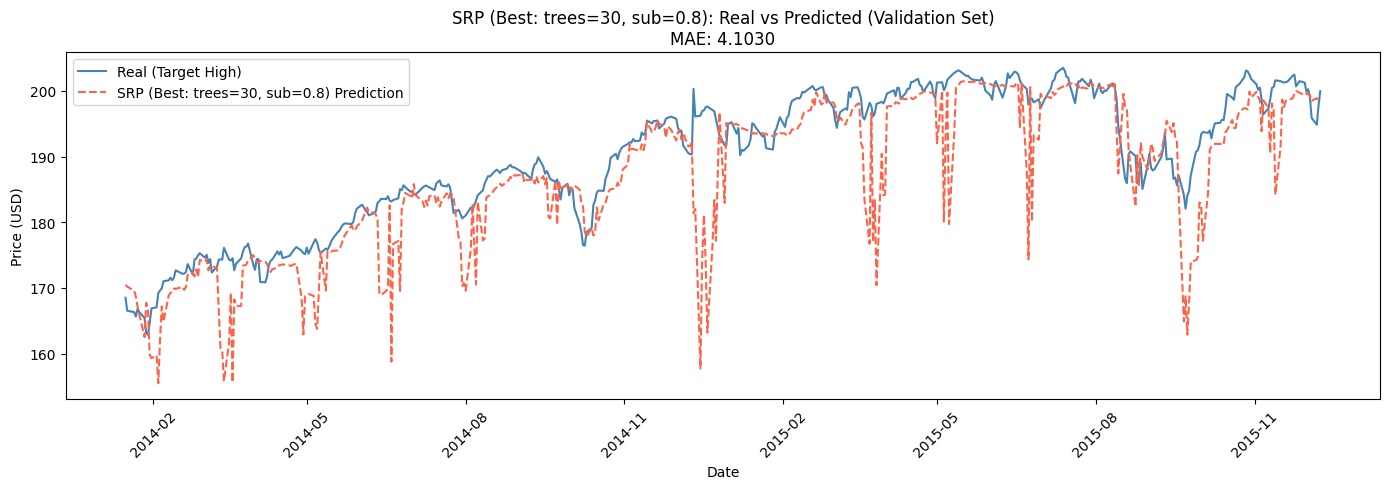

Plot saved as 'images/best_test_predictions_srp.png'


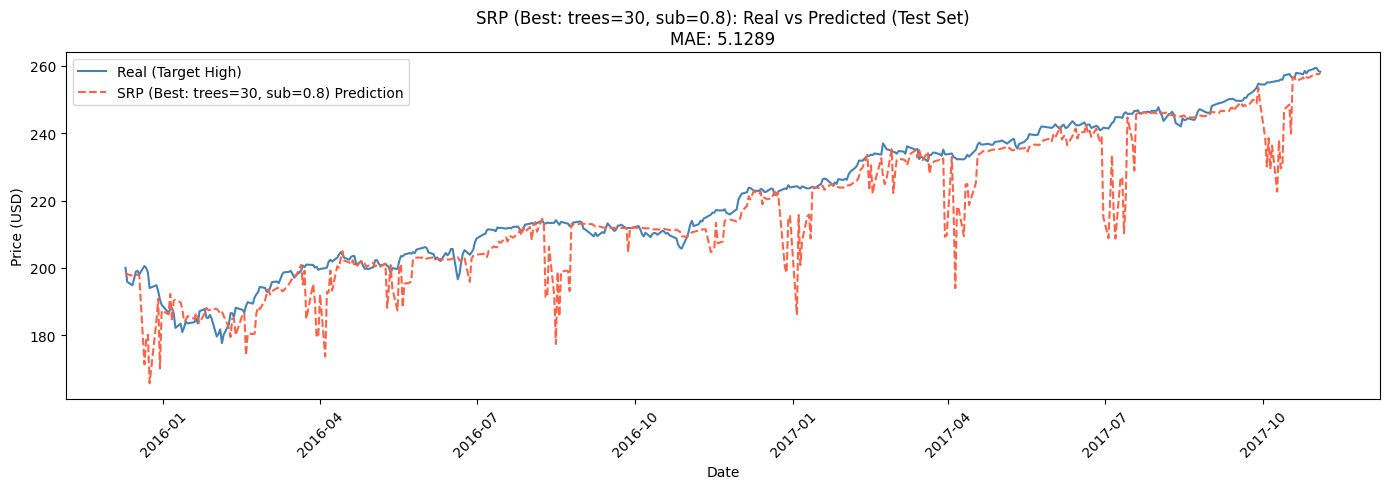

In [27]:
# 1. Define 5 hyperparameter configurations to test for SRP
# n_models: number of trees in the ensemble
# subspace_size: proportion of features to use per tree (Random Subspaces)
# lam: lambda for the Poisson distribution (Online Bagging / Resampling)
configurations_srp = [
    {'n_models': 10, 'subspace_size': 0.6, 'lam': 6.0},
    {'n_models': 20, 'subspace_size': 0.6, 'lam': 6.0},
    {'n_models': 20, 'subspace_size': 0.8, 'lam': 1.0}, # lam=1.0 is standard online bagging
    {'n_models': 30, 'subspace_size': 0.8, 'lam': 6.0}, # lam=6.0 is leveraging bagging (more weight to some instances)
    {'n_models': 30, 'subspace_size': 1.0, 'lam': 1.0}  # 1.0 means all features (like standard bagging)
]

# Variables to keep track of the best model
best_val_mae_srp = float('inf')
best_config_srp = None
best_test_mae_srp = None
best_records_val_srp = []
best_records_test_srp = []

print("Starting Hyperparameter Tuning for Online SRP Regressor...\n")

# 2. Loop through each configuration
for run, config in enumerate(configurations_srp, 1):
    print(f"--- Run {run}/5 | Config: {config} ---")
    
    # We MUST recreate the pipeline from scratch for each run 
    # to prevent the ensemble from carrying over memory from the previous run.
    # We define a base tree, and detectors for warning and drift.
    river_model_srp = compose.Pipeline(
        OnlineSPYFeatures(),
        preprocessing.StandardScaler(), 
        ensemble.SRPRegressor(
            model=tree.HoeffdingTreeRegressor(grace_period=50),
            n_models=config['n_models'],
            subspace_size=config['subspace_size'],
            lam=config['lam'],
            drift_detector=drift.ADWIN(),
            warning_detector=drift.ADWIN(),
            seed=SEED
        )
    )

    # Initialize fresh metrics and lists for this run
    metric_val_srp  = metrics.MAE()
    metric_test_srp = metrics.MAE()
    records_val_srp  = []
    records_test_srp = []

    # 3. Training Loop (Test-then-Train)
    for index, row in df.iterrows():
        x = row[['Open', 'High', 'Low', 'Close', 'Volume']].to_dict()
        y = row['Target_High']
        
        # PREDICTION
        y_pred = river_model_srp.predict_one(x)
        
        # UPDATE METRICS
        if index in X_val.index:
            metric_val_srp.update(y, y_pred)
            records_val_srp.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        elif index in X_test.index:
            metric_test_srp.update(y, y_pred)
            records_test_srp.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        # LEARNING
        river_model_srp.learn_one(x, y)

    # Current run results
    current_val_mae = metric_val_srp.get()
    current_test_mae = metric_test_srp.get()
    print(f"Result -> Val MAE: {current_val_mae:.4f} | Test MAE: {current_test_mae:.4f}\n")

    # 4. Check if this is the best model so far (based on Validation MAE)
    if current_val_mae < best_val_mae_srp:
        best_val_mae_srp = current_val_mae
        best_config_srp = config
        best_test_mae_srp = current_test_mae
        
        # Save the records of the best execution for later plotting
        best_records_val_srp = records_val_srp
        best_records_test_srp = records_test_srp

# 5. Final Results & Plotting
print("="*50)
print("BEST MODEL FOUND")
print(f"Configuration : {best_config_srp}")
print(f"Validation MAE: {best_val_mae_srp:.4f}")
print(f"Test MAE      : {best_test_mae_srp:.4f}")
print("="*50)

# Plot using the records from the best configuration
plot_title = f"SRP (Best: trees={best_config_srp['n_models']}, sub={best_config_srp['subspace_size']})"
mae_srp_val = plot_predictions_online(best_records_val_srp, 'Validation', plot_title, filename=IMG_DIR + 'best_validation_predictions_srp.png')
mae_srp_test = plot_predictions_online(best_records_test_srp, 'Test', plot_title, filename=IMG_DIR + 'best_test_predictions_srp.png')

### Concept Drift Detection (online)

Following the same methodology applied to our batch models, we will now monitor the presence of concept drift in our online models. To do this, we use the `analyze_and_plot_drift_online` function, which applies the ADWIN and Page-Hinkley detectors to the sequential error stream of our online predictions. This allows us to observe when major market shifts occurred and verify if the online models adapted to the new data.


--- Analyzing Concept Drift for Hoefding (Validation) ---
ADWIN detected 2 drift points.
Page-Hinkley detected 5 drift points.
Plot saved as 'images/validation_drift_hoef.png'


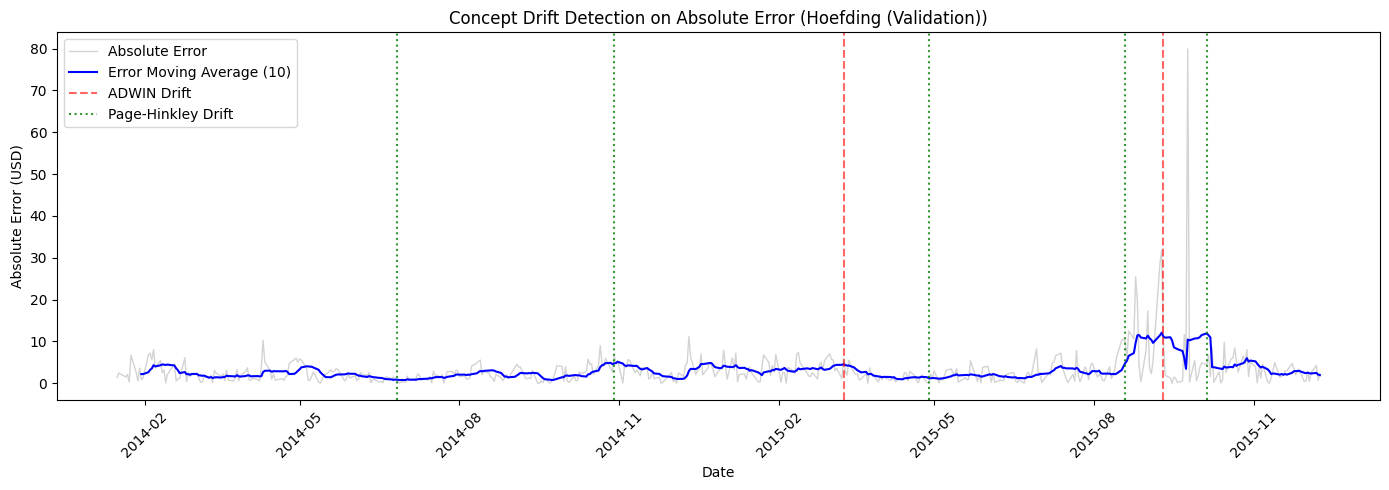


--- Analyzing Concept Drift for Hoefding (Test) ---
ADWIN detected 1 drift points.
Page-Hinkley detected 3 drift points.
Plot saved as 'images/test_drift_hoef.png'


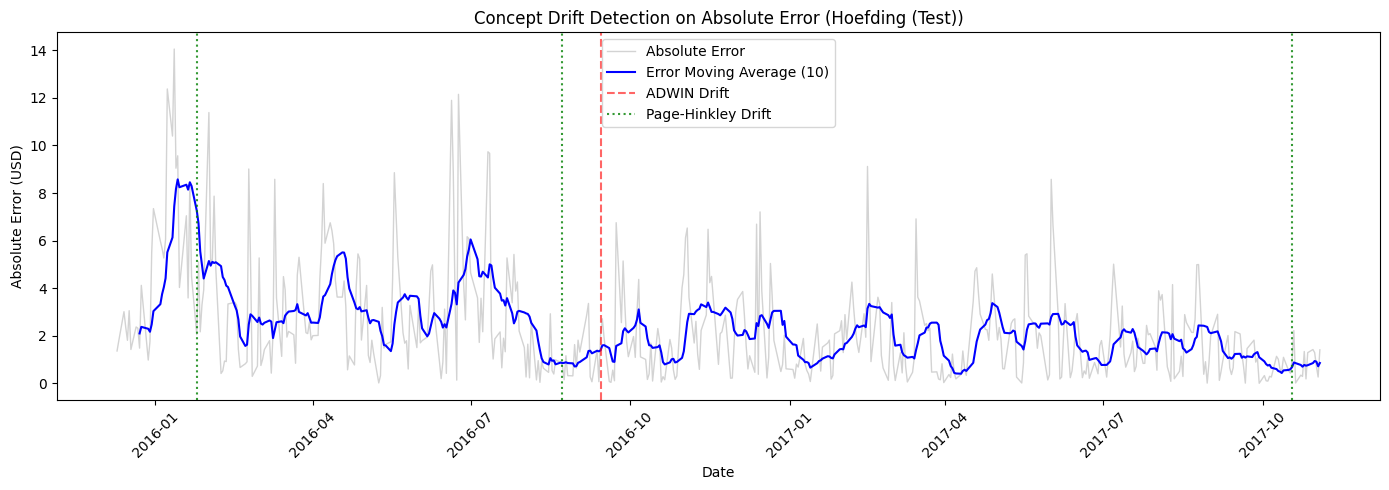

In [28]:
adwin_val_hoef, ph_val_hoef = analyze_and_plot_drift_online(best_records_val_hoef, "Hoefding (Validation)", filename=IMG_DIR + 'validation_drift_hoef.png')
adwin_test_hoef, ph_test_hoef = analyze_and_plot_drift_online(best_records_test_hoef, "Hoefding (Test)", filename=IMG_DIR + 'test_drift_hoef.png')


--- Analyzing Concept Drift for KNN (Validation) ---
ADWIN detected 1 drift points.
Page-Hinkley detected 4 drift points.
Plot saved as 'images/validation_drift_knn.png'


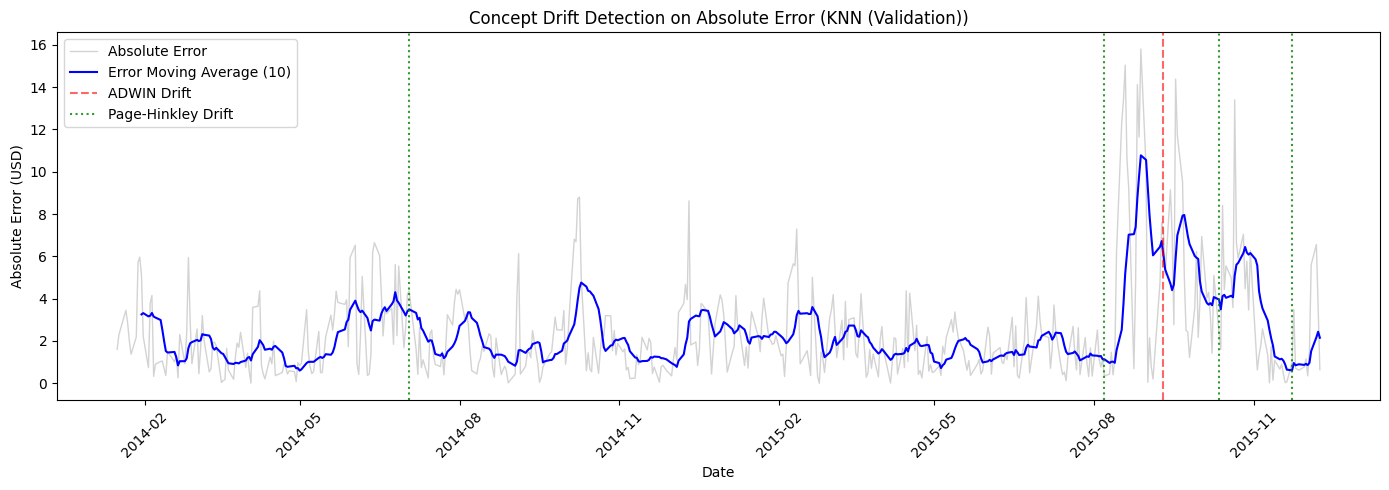


--- Analyzing Concept Drift for KNN (Test) ---
ADWIN detected 2 drift points.
Page-Hinkley detected 7 drift points.
Plot saved as 'images/test_drift_knn.png'


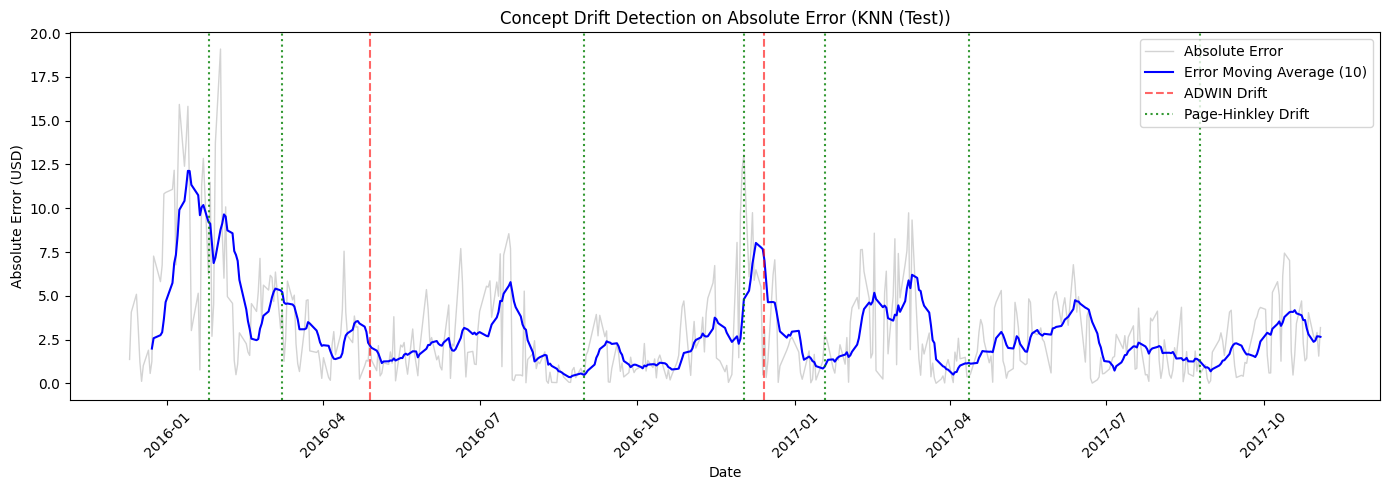

In [29]:
adwin_val_knn, ph_val_knn = analyze_and_plot_drift_online(best_records_val_knn, "KNN (Validation)", filename=IMG_DIR + 'validation_drift_knn.png')
adwin_test_knn, ph_test_knn = analyze_and_plot_drift_online(best_records_test_knn, "KNN (Test)", filename=IMG_DIR + 'test_drift_knn.png')


--- Analyzing Concept Drift for Logistic Regression (Validation) ---
ADWIN detected 2 drift points.
Page-Hinkley detected 6 drift points.
Plot saved as 'images/validation_drift_lr.png'


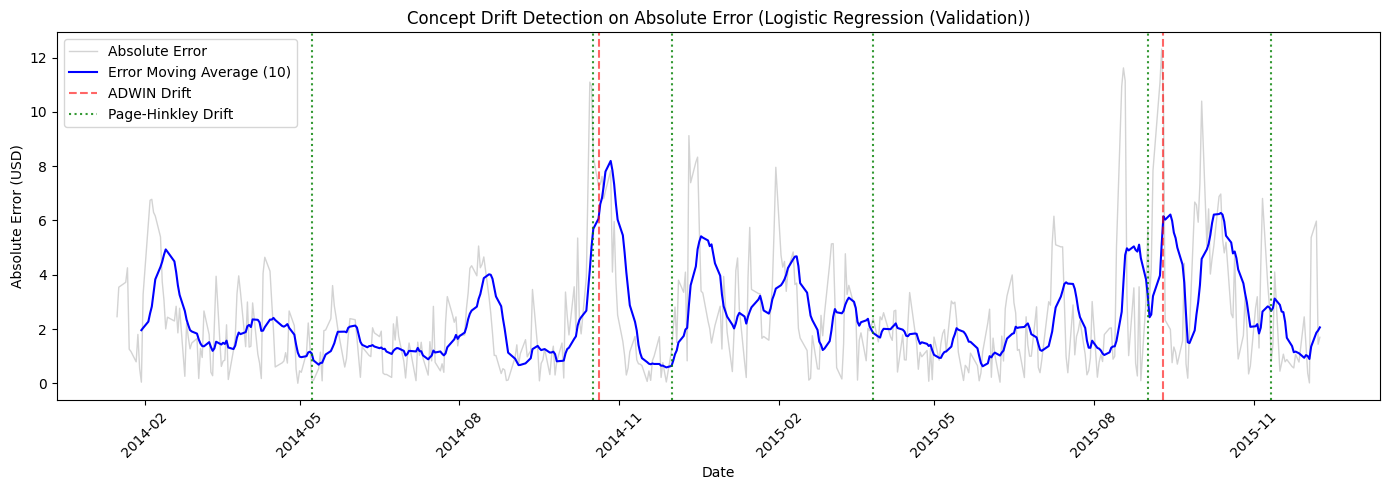


--- Analyzing Concept Drift for Logistic Regression (Test) ---
ADWIN detected 2 drift points.
Page-Hinkley detected 5 drift points.
Plot saved as 'images/test_drift_lr.png'


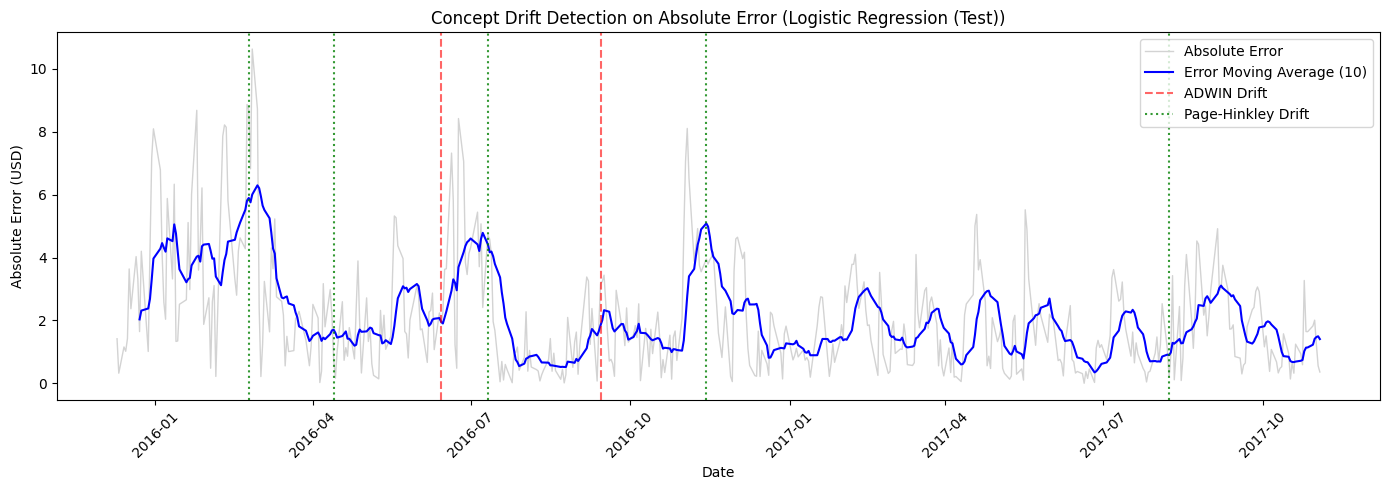

In [30]:
adwin_val_lr, ph_val_lr = analyze_and_plot_drift_online(best_records_val_lr, "Logistic Regression (Validation)", filename=IMG_DIR + 'validation_drift_lr.png')
adwin_test_lr, ph_test_lr = analyze_and_plot_drift_online(best_records_test_lr, "Logistic Regression (Test)", filename=IMG_DIR + 'test_drift_lr.png')


--- Analyzing Concept Drift for SRP (Validation) ---
ADWIN detected 1 drift points.
Page-Hinkley detected 12 drift points.
Plot saved as 'images/validation_drift_srp.png'


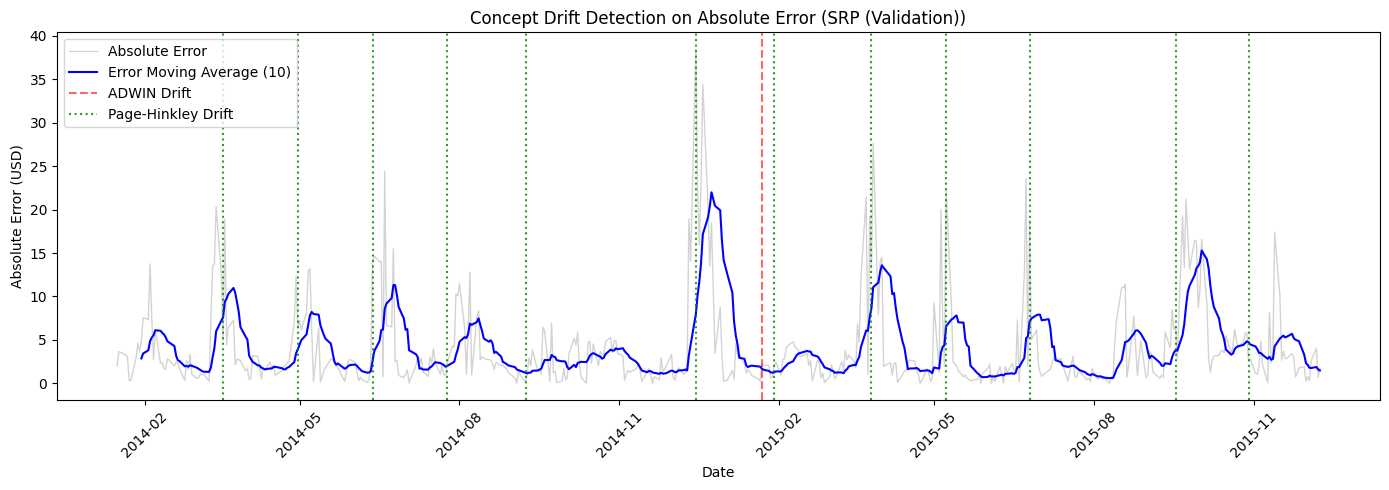


--- Analyzing Concept Drift for SRP (Test) ---
ADWIN detected 0 drift points.
Page-Hinkley detected 14 drift points.
Plot saved as 'images/test_drift_srp.png'


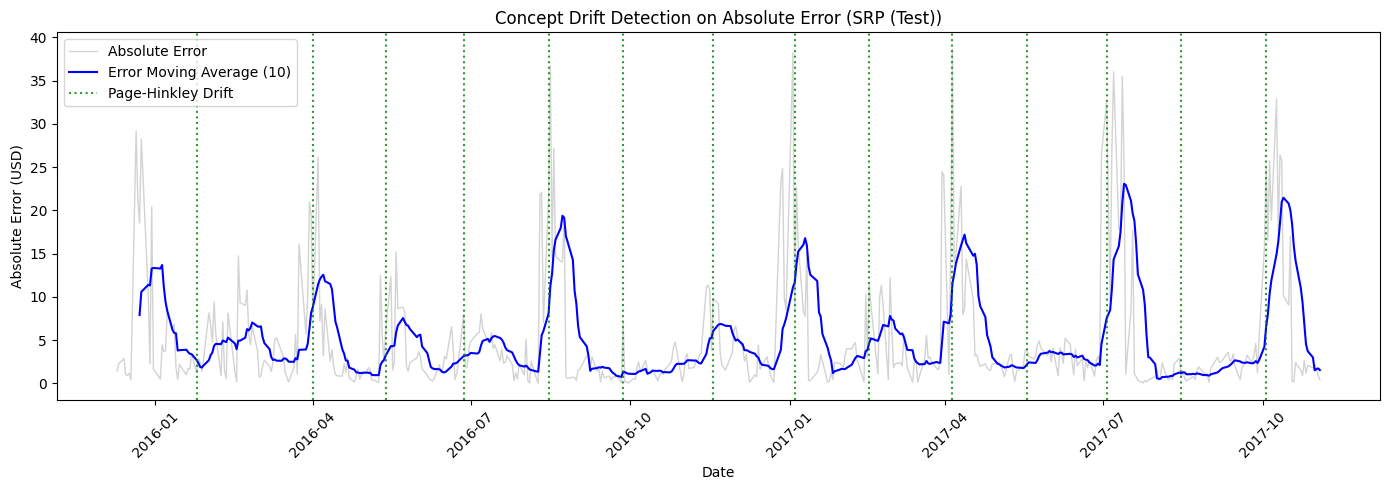

In [31]:
adwin_val_srp, ph_val_srp = analyze_and_plot_drift_online(best_records_val_srp, "SRP (Validation)", filename=IMG_DIR + 'validation_drift_srp.png')
adwin_test_srp, ph_test_srp = analyze_and_plot_drift_online(best_records_test_srp, "SRP (Test)", filename=IMG_DIR + 'test_drift_srp.png')

### Analyzing Concept Drift in Stream Models

The charts above visualize the absolute error and the concept drift alerts (via ADWIN and Page-Hinkley) for our Stream Learning models. Comparing these charts to the batch model drift charts reveals the core advantage of online learning.

**The Error Trend:**
In the batch models, the blue moving average line of the error showed a continuous, undeniable upward trajectory as time went on—the model was slowly becoming obsolete. 

In contrast, the error trend for the stream models (like the Hoeffding Tree and SRP) is noticeably more stable and horizontal. Because the models update their internal parameters with every new observation, they prevent the error from accumulating exponentially.

**Interpreting the Drift Detectors in an Online Context:**
You will notice that ADWIN and Page-Hinkley still occasionally trigger drift alerts (the red and green lines). This is expected; the stock market frequently experiences sudden volatility shocks or macroeconomic shifts that temporarily spike the prediction error. 

However, the meaning of these alerts is fundamentally different here:
* **For Batch Models:** A drift alert signaled a permanent degradation in performance. The model was broken and needed to be manually retrained.
* **For Stream Models:** A drift alert simply marks a period of high market turbulence. Notice that after an alert is triggered in the stream charts, the error moving average typically **recovers and drops back down**. The model successfully ingested the new, volatile data, updated its rules, and corrected its course automatically.


### Batch vs. Stream Learning Comparison

To fully understand the benefits of stream learning on financial data, we compare the final Test MAE of our best Batch models against our Stream models. 

Because financial markets experience concept drift, static Batch models naturally degrade in performance as time goes on. Stream models, however, continuously update their internal weights with each new observation, allowing them to adapt to changing market conditions and maintain a lower, more stable error rate.

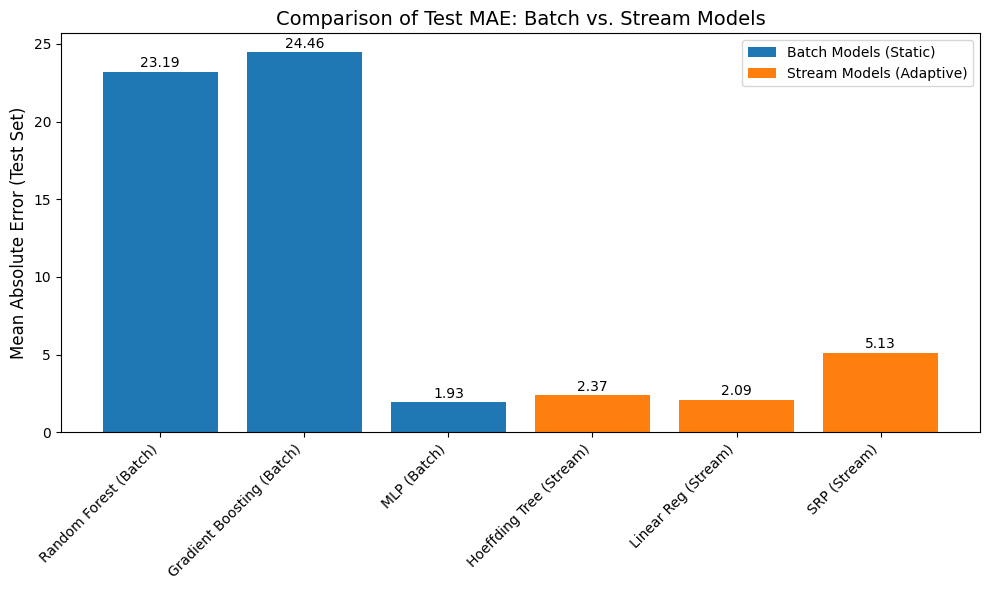

In [ ]:
model_names = ['Random Forest (Batch)', 'Gradient Boosting (Batch)', 'MLP (Batch)', 
               'Hoeffding Tree (Stream)', 'Linear Reg (Stream)', 'SRP (Stream)']

test_maes = [
    mae_best_test,     # Batch Random Forest Test MAE
    mae_best_gb_test,     # Batch Gradient Boosting Test MAE
    mae_best_mlp_test,    # Batch MLP Test MAE
    best_test_mae_hoef,   # Stream Hoeffding Tree Test MAE
    best_test_mae_lr,     # Stream Linear Regression Test MAE
    best_test_mae_srp     # Stream SRP Test MAE
]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, test_maes, color=['#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e'])

plt.ylabel('Mean Absolute Error (Test Set)', fontsize=12)
plt.title('Comparison of Test MAE: Batch vs. Stream Models', fontsize=14)
plt.xticks(rotation=45, ha='right')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#1f77b4', label='Batch Models (Static)'),
                   Patch(facecolor='#ff7f0e', label='Stream Models (Adaptive)')]
plt.legend(handles=legend_elements, loc='upper right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(IMG_DIR + 'batch_vs_stream_comparison.png')
plt.show()

## Conclusions and Future Work

**Conclusions:**
In this analysis, our highly tuned Multilayer Perceptron (MLP) batch model ultimately outperformed the stream learning models in terms of Test MAE. This result highlights the predictive power of a well-optimized batch architecture, particularly when significant effort is dedicated to feature engineering and hyperparameter tuning—areas where we have a stronger foundational comfort. 

However, the results from the stream processing models were still highly encouraging. Despite being less manually optimized than the MLP, the average stream model (such as Streaming Random Patches) delivered strong performance and demonstrated the inherent advantage of continuous adaptation.

**Open Questions and Future Work:**
While our batch MLP took the lead, predicting the SPY ETF remains an incredibly complex, noisy problem. Future iterations of this project could explore the following:
1. **Tuning Stream Models:** Given the performance boost achieved by aggressively tuning the MLP, future work should dedicate similar effort to hyperparameter optimization for River's stream models (e.g., tweaking ensemble sizes, tree depths, and learning rates) to see if they can eventually surpass the batch baseline.
2. **Hybrid Architectures:** We could explore online deep learning or hybrid systems that combine the complex pattern recognition of our batch MLP with an online updating mechanism, preventing the eventual degradation caused by concept drift.
3. **Alternative Data Sources:** Stock prices are heavily influenced by exogenous factors. Future iterations should incorporate sentiment analysis from financial news APIs or macroeconomic indicators as additional features in the data stream.

## Conclusions and Future Work

The core takeaway from this project is the empirical demonstration of concept drift and its impact on machine learning models. While our heavily optimized batch model (the MLP) achieved the lowest overall Test MAE, the analysis exposed the fundamental flaw of deploying static models in dynamic environments. The statistical drift detectors (ADWIN and Page-Hinkley) proved that the mapping between features and the target variable shifted significantly over time, causing the tree-based batch models to hit artificial ceilings (the "flatlining" effect) and degrade.

Conversely, this analysis validated the continuous adaptability of online stream models. While algorithms like the Hoeffding Tree or Streaming Random Patches might start with simpler representations, their incremental learning mechanism allows them to constantly update their internal parameters. When the underlying data distribution shifted, these models dynamically adjusted to the new patterns without requiring manual retraining. This proves that for continuous, non-stationary data streams, the capacity to learn on the fly is a critical architectural requirement.

**Open Questions and Future Work:**
To expand on the theoretical analysis of stream learning, future work should explore the following:
1. **Testing on Live, Out-of-Sample Data:** The most critical next step is to evaluate these stream models on entirely new, recent data (e.g., pulling SPY ETF data from the last 12-24 months via a live API). Testing outside our provided dataset will allow us to observe how the models react to modern macroeconomic shocks and verify their long-term robustness.
2. **Analysis of Feature Space Drift:** In this project, we primarily monitored the error stream for concept drift. Future iterations could implement detectors directly on the input features (Covariate Shift) to understand if changes in the independent variables (like volume or volatility) reliably precede the degradation of model performance.
